## Python3 code to read Persist Task eprime output files (txt output)
Jamil Bhanji<br>
bhanji@psychology.rutgers.edu<br>
April 18, 2018<br>

In [1]:
import os
import sys
import json
import codecs
import pandas as pd
import io
import chardet
import codecs
import numpy as np


In [2]:
topdir = "/mnt/delgadolab/jamil/opiod_mita" #study directory (full path)
bidstsvformat = topdir + '/BIDS/sub-%s/func/sub-%s_task-%s_run-%s_events.tsv' #format for saving tsv file
# func_tasks = { 
#     "cardtask": "CardTaskRPN_order1-101-1",
#     "persist": "PathTaskfmri_order1-101-1"
# } #would be nice to just iterate through all files but they are too idosyncratic at the moment
# sub-627 removed due to low RTs
subjectlist = ['601','603','604','605','606','607','608','609','610','615','616','617','618','620','622','624','626','628','629','630',
               '802','803','804','806','808','809','810','811','812','813','814','815','816','817','818','819','820','821','822','823']
group_list = ["Opioid", "Control"]
patient_group_list = ["Opioid", "Control"]
subject_groups = { 
    "Opioid": ['601','603','604','605','606','607','608','609','610','615','616','617','618','620','622','624','626','628','629','630'], #after each groupname include participant labels list
    "Control": ['802','803','804','806','808','809','810','811','812','813','814','815','816','817','818','819','820','821','822','823']
} 

### Generate \_events.tsv for the persist task (pathtask)
* event onsets for choice, obstacle response (cue), obstacle feedback, goal feedback 
* persist choice, choice rt, obstacle rt stored in an additional columns
* event types (this version does not include the lodiff condition, but it is listed for consistency):
    * __sbkuncconhidiff__ - controllable obstacle, hidiff condition
    * __posuncconhidiff__ - uncontrollable lodiff setback (negative feedback)
    * __cueuncconhidiff__ - controllable lodiff setback (negative feedback)
    * __poscuefbk__ - uncontrollable hidiff setback (negative feedback)
    * __sbkconhidiff__ - controllable hidiff setback (negative feedback)
    * __postuncconhidiffchoice__ - uncontrollable lodiff avoided setback
    * __goalpos__ - end of path reached
    * __goalneg__ - goal not reached
    * __miss__ - missed path choice
    
* in the future, write code to autogenerate participants.tsv with columns for emotion ratings from the e-prime file

In [85]:
def persist_eprime_txt_to_tsv(infile, encodingtype, outfile, group):
    """
    Read e-prime style txt from PathTask_fmri E-Prime (1 scan)
    Output a tab separated file (1 for each scan), BIDS compliant
    """    
    #nruns = len(outfiles)
    events_per_run = 88 #this counts cue and feedback as 1 event, but they will get entered as separate events in the tsv (modeled separately)
    misschoicecount = 0
    misscuecount = 0
    with codecs.open(infile, encoding=encodingtype) as f:
        text_data = list(f)
        trimmed_data = [str.strip(line) for line in text_data]
        # Determine start and end rows of each trial.
        #trialstarts = [i for i, line in enumerate(trimmed_data) if 'EventList1: ' in line] 
        trialstarts = [i for i, line in enumerate(trimmed_data) if '*** LogFrame Start ***' in line][:-1] #last one is summary info (drop it)
        trialends = [i for i, row in enumerate(trimmed_data) if row == '*** LogFrame End ***'][:-1] #last one is summary info (drop it)
        #print(trialstarts, len(trialstarts))
        outdf = pd.DataFrame(columns=['onset','duration','trial_type','persist_choice','switch_choice','response_time', 'group', 'path'])
        #runnum = runidx+1
        #runfirstevent = runidx*events_per_run
        #current_trialstarts = trialstarts[runfirstevent:((runidx+1)*events_per_run)]
        #print ("run %02d startlines:" % runnum)
        #print (current_trialstarts, len(current_trialstarts))
        for counter, startidx in enumerate(trialstarts):  #trial loop start
            endidx = trialends[counter]
            onetrial = trimmed_data[startidx:endidx]
            #print(counter,startidx, endidx)
            for line in onetrial:
                if "EventType:" in line:
                    event = int(line.split(":")[1]) #1=unccue,2=concue,3=poscue,4=pathchoice,6=goalfbk
                if "ChoosePath.OnsetTime:" in line:
                    eprime_choice_onset = int(line.split(":")[1])/1000
                    if counter == 0:
                        trigger = eprime_choice_onset - 4 #4s fixation between scan trigger and first trial
                    choice_onset = eprime_choice_onset - trigger
                if "GoalFbk.OnsetTime:" in line:
                    goal_onset = int(line.split(":")[1])/1000 - trigger
                if "ue.OnsetTime:" in line: #matches greencue onset and cue onset
                    cue_onset = int(line.split(":")[1])/1000 - trigger
                if ("Fbk.OnsetTime:" in line) and (not ("GoalFbk" in line)) : #matches greenfbk onset and fbk onset
                    fbk_onset = int(line.split(":")[1])/1000 - trigger
                if "Lose:" in line:
                    lose = int(line.split(":")[1]) #0=nosetback, 1=setback
                if "ValueDiff:" in line:
                    valuediff = int(line.split(":")[1]) #1=lodiff, 2=hidiff
                if "NewRound:" in line:
                    newround = int(line.split(":")[1]) #1=first choice of round
                if "condition:" in line:
                    conditionstr = str.strip(line.split(":")[1])
                if "PostCuejit:" in line:
                    postcuejit = int(line.split(":")[1])/1000
                if "PostFbkjit:" in line:
                    postfbkjit = int(line.split(":")[1])/1000
                if "ChoosePath.RT:" in line:
                    choice_rt = int(line.split(":")[1])/1000
                if "postChoiceFixation.RT:" in line:
                    latechoice_rt = int(line.split(":")[1])/1000
                if "Cue.RT:" in line:
                    cue_rt = int(line.split(":")[1])/1000
                if "Persist:" in line:
                    persist_choice = int(line.split(":")[1])
                if "Switch:" in line:
                    switch_choice = int(line.split(":")[1])
                if ("Path:" in line) and (not("LastPath" in line)):
                    current_path = int(line.split(":")[1])
                if "yescap" in line:
                    goal_event = "goalpos"
                if "nocap" in line:
                    goal_event = "goalneg"
            valuestr = "hidiff" if valuediff == 2 else "lodiff"
            condabbrev = "unccon" if conditionstr == "uncontrollable" else "unccon"
            fbkval = "pos" if lose == 0 else "sbk"
            if event==4:
                #pathchoice event
                event_onset = choice_onset
                if (choice_rt == 0 and latechoice_rt == 0):
                    trial_type = "miss"
                    misschoicecount += 1
                    response_time = float('nan')
                else:
                    response_time = 2 + latechoice_rt if choice_rt == 0 else choice_rt
                    if newround == 1:
                        trial_type = "firstchoice"
                    else:
                        trial_type = "post%s%schoice" % (condabbrev,valuestr)
                trial_duration = 2
                outdf = outdf.append({'onset': event_onset,'duration': trial_duration, 'trial_type': trial_type, 
                                      'persist_choice':persist_choice, 'switch_choice':switch_choice, 
                                      'response_time': response_time, 'group': group, 'path':current_path}, ignore_index=True)
            elif event==6: #goal fbk event
                event_onset = goal_onset
                trial_type = goal_event
                trial_duration = 2
                response_time = float('nan')
                outdf = outdf.append({'onset': event_onset,'duration': trial_duration, 'trial_type': trial_type, 
                                      'response_time': response_time, 'group': group, 'path':current_path}, ignore_index=True)
            elif event==3: #progress cue event
                event_onset = cue_onset
                trial_type = "poscuefbk"
                trial_duration = 4
                response_time = cue_rt if cue_rt > 0 else float('nan')
                outdf = outdf.append({'onset': event_onset,'duration': trial_duration, 'trial_type': trial_type, 
                                      'response_time': response_time, 'group': group, 'path':current_path}, ignore_index=True)
            elif (event==1 or event==2): #unc obstacle
                cue_type = "cue%s%s" % (condabbrev,valuestr)
                fbk_type = "%s%s%s" % (fbkval,condabbrev,valuestr)
                if cue_rt > 0:
                    outdf = outdf.append({'onset': cue_onset,'duration': 2, 'trial_type': cue_type, 
                                          'response_time': cue_rt, 'group': group, 'path':current_path}, ignore_index=True)
                    outdf = outdf.append({'onset': fbk_onset,'duration': 2, 'trial_type': fbk_type, 
                                          'response_time': float('nan'), 'group': group, 'path':current_path}, ignore_index=True)
                else:
                    misscuecount += 1
                    outdf = outdf.append({'onset': cue_onset,'duration': 2, 'trial_type': "miss", 'response_time': cue_rt, 
                                          'group': group, 'path':current_path}, ignore_index=True)
                    outdf = outdf.append({'onset': fbk_onset,'duration': 2, 'trial_type': "miss", 'response_time': float('nan'),
                                          'group': group, 'path':current_path}, ignore_index=True)

            event=0 #reset event (fixes last line problem)
        #trialloop end
    choice_idxs = outdf.loc[(outdf.trial_type=='postuncconhidiffchoice') | 
                         (outdf.trial_type=='postuncconlodiffchoice') |
                         (outdf.trial_type=='postuncconhidiffchoice') |
                         (outdf.trial_type=='postuncconlodiffchoice')].index
    sbk_idxs = choice_idxs - 1
    for counter, row_idx in enumerate(sbk_idxs): #fill setback rows with subsequent choice info
        outdf.loc[row_idx,'persist_choice'] = outdf.loc[choice_idxs[counter],'persist_choice']
        outdf.loc[row_idx,'switch_choice'] = outdf.loc[choice_idxs[counter],'switch_choice']
    outdf = outdf.round(3)
    print('%d missed choices\n' % misschoicecount)
    print('%d missed cues\n' % misscuecount)
    if not ("miss" in outdf['trial_type'].values):  #add empty row if no missed trials
        outdf = outdf.append({'onset': 0,'duration': 0, 'trial_type': "miss", 'response_time': float('nan')}, ignore_index=True)
    outdf.to_csv(outfile, sep='\t', float_format='%.3f', index=False)

In [86]:
def BIDStoFSL3col(bidseventfile,basename):
    cmd = '/mnt/delgadolab/generaltools/bidsutils/BIDSto3col/BIDSto3col.sh %s %s' % (bidseventfile,basename)
    #print (cmd)
    !{cmd}

In [87]:
# read e-prime txt files and output event.tsv
# subjectlist = ['601','603','604','605','606','607','608','609','610','615','616','617','618','620',
#                '802','803','804','806','807','808','809','810','811','812']
eprimepathformat = topdir + "/sourcedata/behavior/PersistTask" #to construct pathname

for igroup, group in enumerate(group_list):
    for isub, sub in enumerate(subject_groups[group]):
        print ("subject %s persist task" % (sub))
        eprime_dir = eprimepathformat
        taskname = "persist"
        runnum = "01"
        infile = eprime_dir + "/PathTaskfmri_order1-%s-1.txt" % (sub)
        #check encoding type (utf-16 or utf-8)
        bytes = min(32, os.path.getsize(infile))
        raw = open(infile, 'rb').read(bytes)
        result = chardet.detect(raw)
        encodingtype = result['encoding'] #pass this encoding type var to the routine that reads the files 
        bidsoutfile = bidstsvformat % (sub, sub, taskname, runnum)
        #multiple runs??
    #     outfiles = []
    #     for runidx in range(nruns):
    #         runstr = '%02d' % (runidx + 1)
    #         outfiles.append( bidstsvformat % (sub, sub, taskname, runstr))

        FSL3colfolder = topdir + "/analysis/persist/sub-%s/uncconpersistmodel/onsets" % (sub)
        FSL3colbasename = FSL3colfolder + "/uncconpersistmodel"
#        os.makedirs(FSL3colfolder, exist_ok=True)
        #print (infile)
        #print(FSL3colbasename)
        persist_eprime_txt_to_tsv(infile,encodingtype,bidsoutfile,group)
        #BIDStoFSL3col(bidsoutfile, FSL3colbasename)
    


subject 601 persist task
4 missed choices

0 missed cues

subject 603 persist task
0 missed choices

1 missed cues

subject 604 persist task
0 missed choices

0 missed cues

subject 605 persist task
1 missed choices

0 missed cues

subject 606 persist task
2 missed choices

1 missed cues

subject 607 persist task
3 missed choices

3 missed cues

subject 608 persist task
0 missed choices

1 missed cues

subject 609 persist task
1 missed choices

0 missed cues

subject 610 persist task
2 missed choices

0 missed cues

subject 615 persist task
0 missed choices

3 missed cues

subject 616 persist task
0 missed choices

2 missed cues

subject 617 persist task
5 missed choices

1 missed cues

subject 618 persist task
0 missed choices

0 missed cues

subject 620 persist task
6 missed choices

9 missed cues

subject 622 persist task
0 missed choices

0 missed cues

subject 624 persist task
2 missed choices

0 missed cues

subject 626 persist task
0 missed choices

1 missed cues

subject 628 pe

In [3]:
# Read behavioral data into pandas dataframe and create restructured (1 row per sub) file
# subjectlist = ['601','603','604','605','606','607','608','609','610','615','616','617','618','620',
#                '802','803','804','806','807','808','809','810','811','812']

excludelist = [] #["627"]
eprimepathformat = topdir + "/PersistTask" #to construct pathname
taskname = "persist"
runnum = "01"

stacked_behav_df = pd.DataFrame(columns=['subject','group','onset','duration','trial_type','persist_choice','switch_choice','response_time','path'])
restruct_behav_df = pd.DataFrame(columns=['subject','group','persist_percent','switch_percent','path_response_time','cue_response_time',
                                          'firstchoiceA','firstchoiceB','firstchoiceC','persistAsum','persistAopps',
                                          'persistBsum','persistBopps','persistCsum','persistCopps','pathAchoices'])
for sub in subjectlist:
    if not (sub in excludelist):
        eventsfile = bidstsvformat % (sub, sub, taskname, runnum)
        sub_df = pd.read_csv(eventsfile,sep='\t')
        sub_df['subject']=sub
        group = sub_df['group'][0]
        misschoicecount = sub_df.loc[sub_df.trial_type=='postuncconhidiffchoice','persist_choice'].isna().sum()
        persist_percent = sub_df.loc[sub_df.trial_type=='postuncconhidiffchoice',:].persist_choice.sum() / 20
        pathAchoices = sub_df.loc[(sub_df.trial_type=='postuncconhidiffchoice') & (sub_df.path==1),'persist_choice'].shape[0]
        persistAsum = sub_df.loc[(sub_df.trial_type=='postuncconhidiffchoice') & (sub_df.path==1),'persist_choice'].sum()
        choice_idxs = sub_df.loc[(sub_df.trial_type=='postuncconhidiffchoice')].index
        persistAopps = sub_df.loc[(sub_df.trial_type=='sbkuncconhidiff') & (sub_df.path==1),:].shape[0]
        persistBsum = sub_df.loc[(sub_df.trial_type=='postuncconhidiffchoice') & (sub_df.path==2),'persist_choice'].sum()
        persistBopps = sub_df.loc[(sub_df.trial_type=='sbkuncconhidiff') & (sub_df.path==2),:].shape[0]
        persistCsum = sub_df.loc[(sub_df.trial_type=='postuncconhidiffchoice') & (sub_df.path==3),'persist_choice'].sum()
        persistCopps = sub_df.loc[(sub_df.trial_type=='sbkuncconhidiff') & (sub_df.path==3),:].shape[0]
        switch_percent = sub_df.loc[sub_df.trial_type=='postuncconhidiffchoice',:].switch_choice.sum() / 20
        path_response_time = sub_df.loc[sub_df.trial_type=='postuncconhidiffchoice',:].response_time.mean()
        cue_response_time = sub_df.loc[sub_df.trial_type=='cueuncconhidiff',:].response_time.mean()
        misschoicecount = (sub_df['trial_type']=='miss').sum()
        missedfirstchoice = 10 - sub_df.loc[(sub_df.trial_type=='firstchoice')].shape[0]
        firstchoiceA = sub_df.loc[(sub_df.trial_type=='firstchoice') & (sub_df.path==1)].shape[0] + missedfirstchoice
        firstchoiceB = sub_df.loc[(sub_df.trial_type=='firstchoice') & (sub_df.path==2)].shape[0]
        firstchoiceC = sub_df.loc[(sub_df.trial_type=='firstchoice') & (sub_df.path==3)].shape[0]
        restruct_behav_df = restruct_behav_df.append({'subject': sub, 'group': group,
                                                      'persist_percent': persist_percent, 
                                                      'switch_percent': switch_percent, 
                                                      'path_response_time': path_response_time, 
                                                      'cue_response_time': cue_response_time,
                                                      'firstchoiceA': firstchoiceA,
                                                      'firstchoiceB': firstchoiceB,
                                                      'firstchoiceC': firstchoiceC,
                                                      'persistAsum': persistAsum,
                                                      'persistAopps': persistAopps,
                                                      'persistBsum': persistBsum,
                                                      'persistBopps': persistBopps,
                                                      'persistCsum': persistCsum,
                                                      'persistCopps': persistCopps,
                                                      'pathAchoices': pathAchoices}, ignore_index=True)
        stacked_behav_df = stacked_behav_df.append(sub_df)



In [4]:
import seaborn as sns
palette = sns.color_palette("muted")
palette2col = sns.color_palette(['#4878d0', '#6acc64'])
#sns.palplot(palette2col)


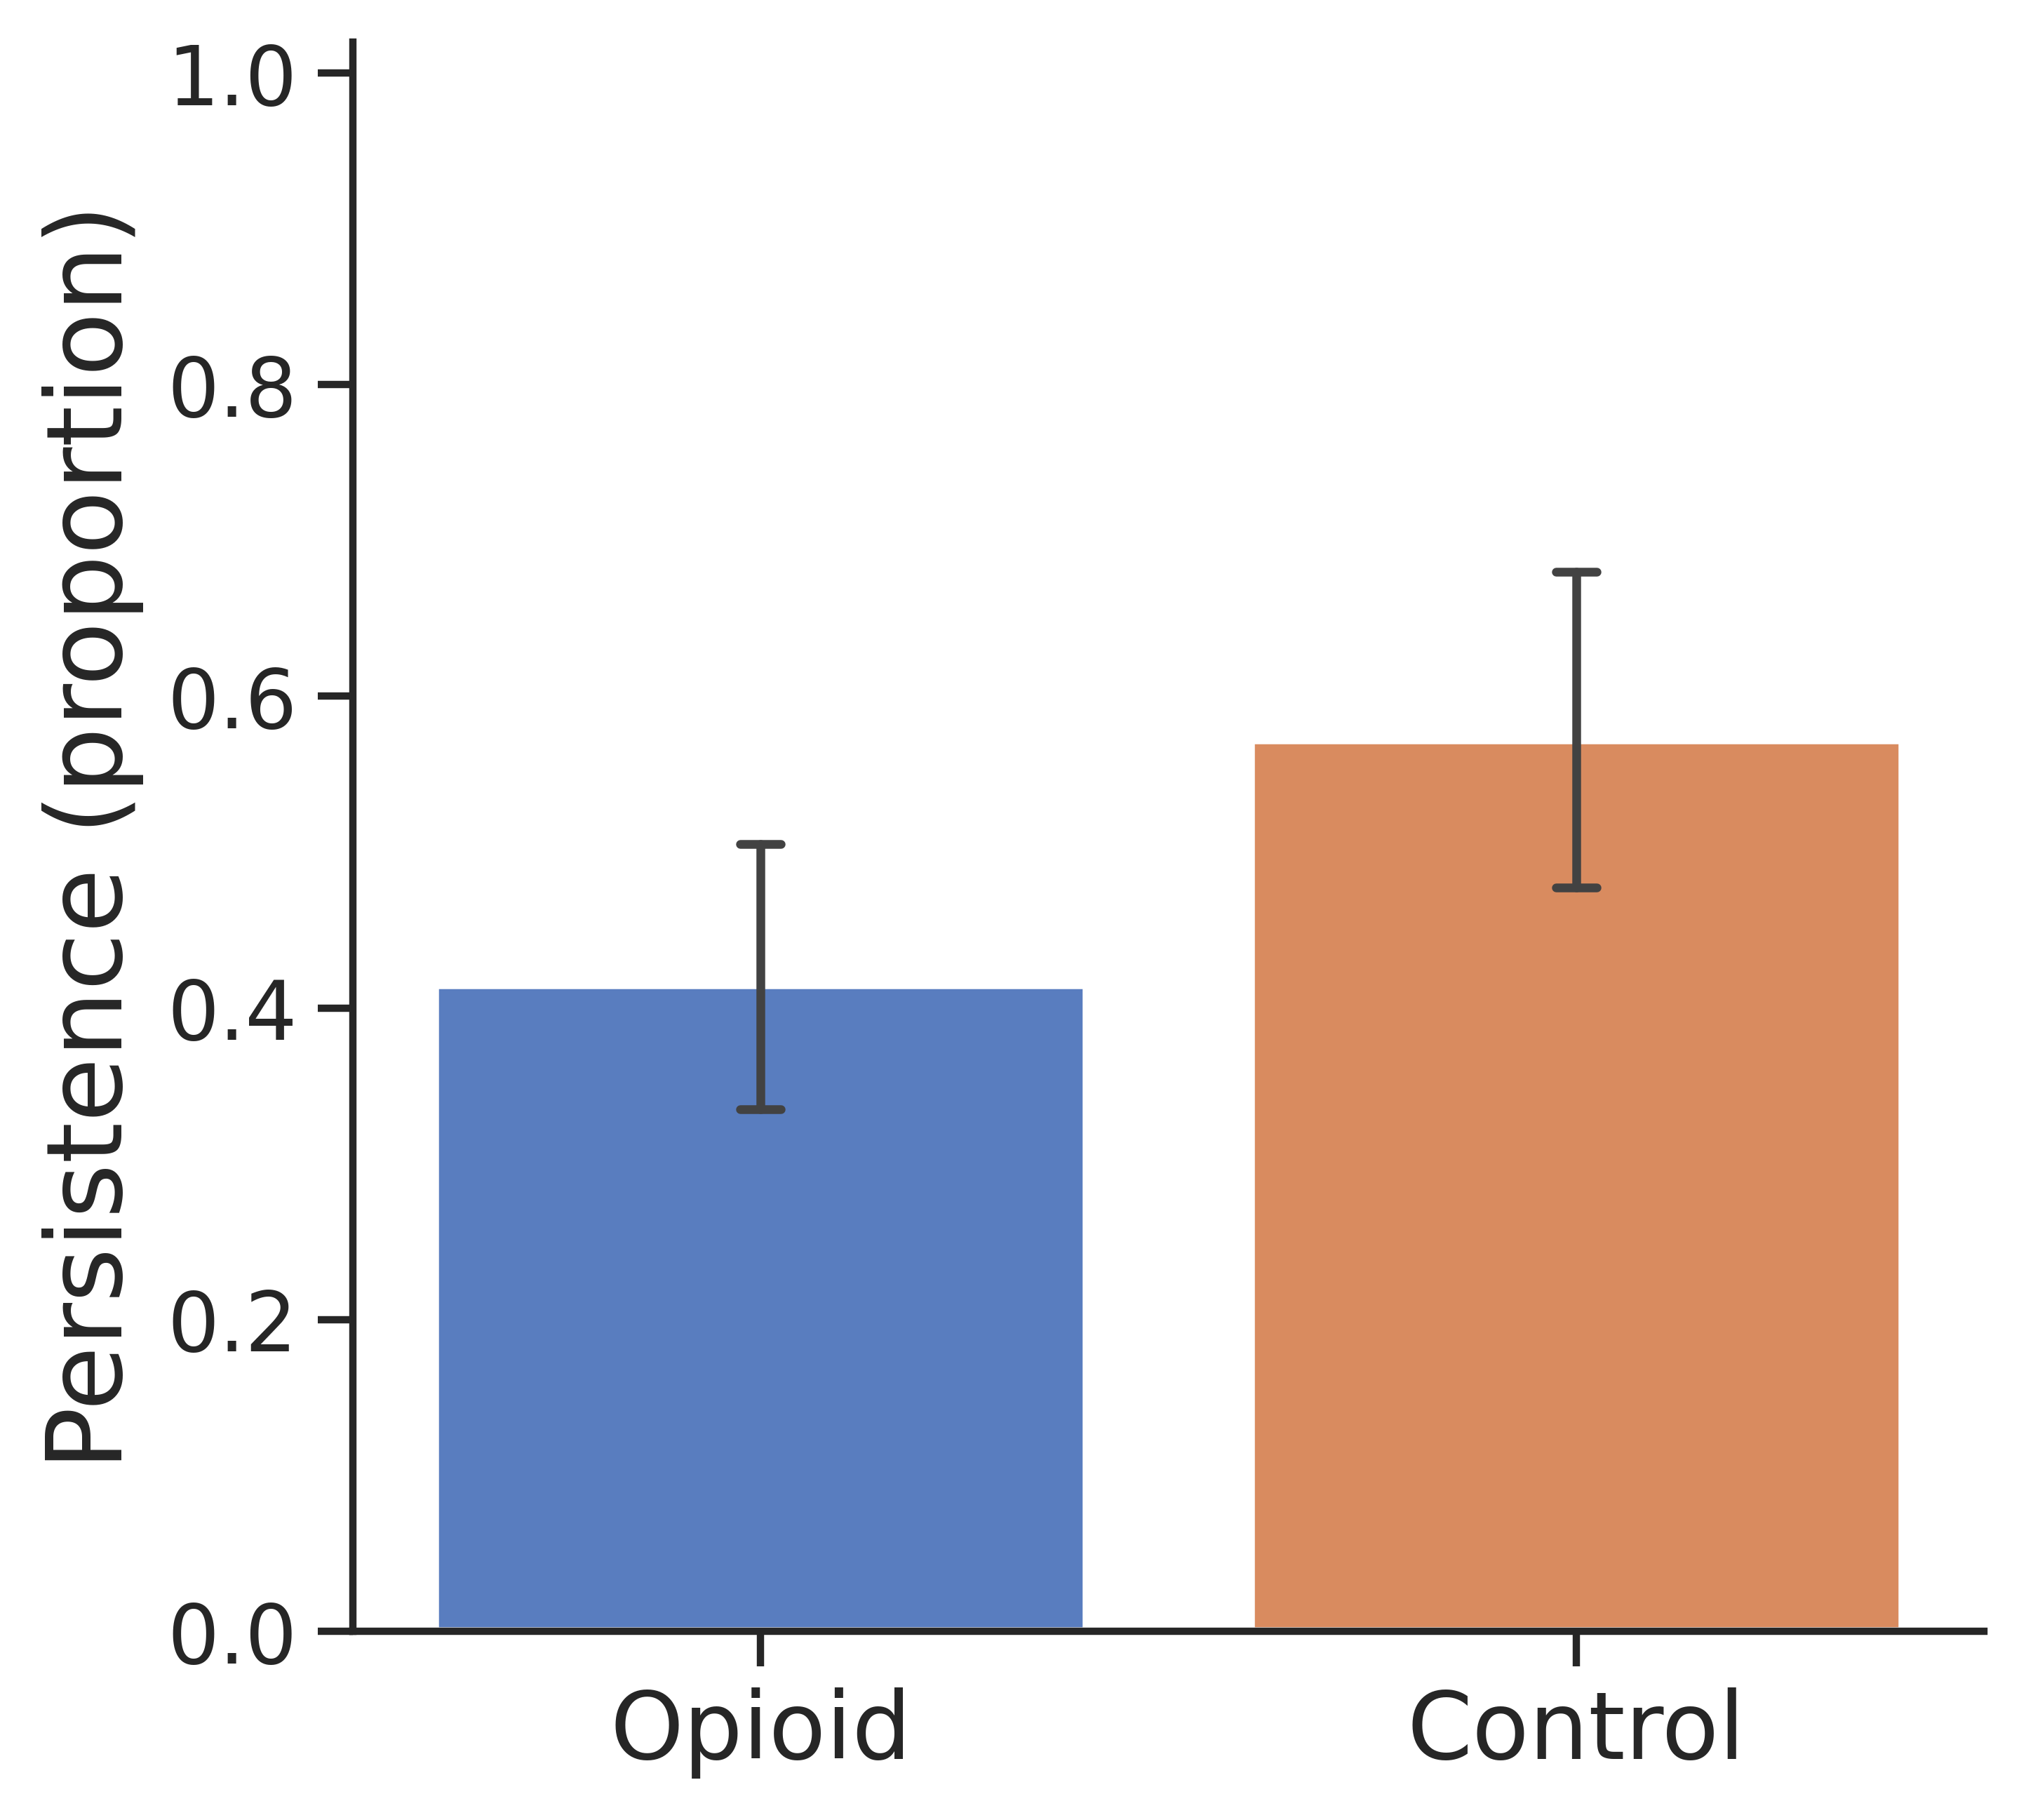

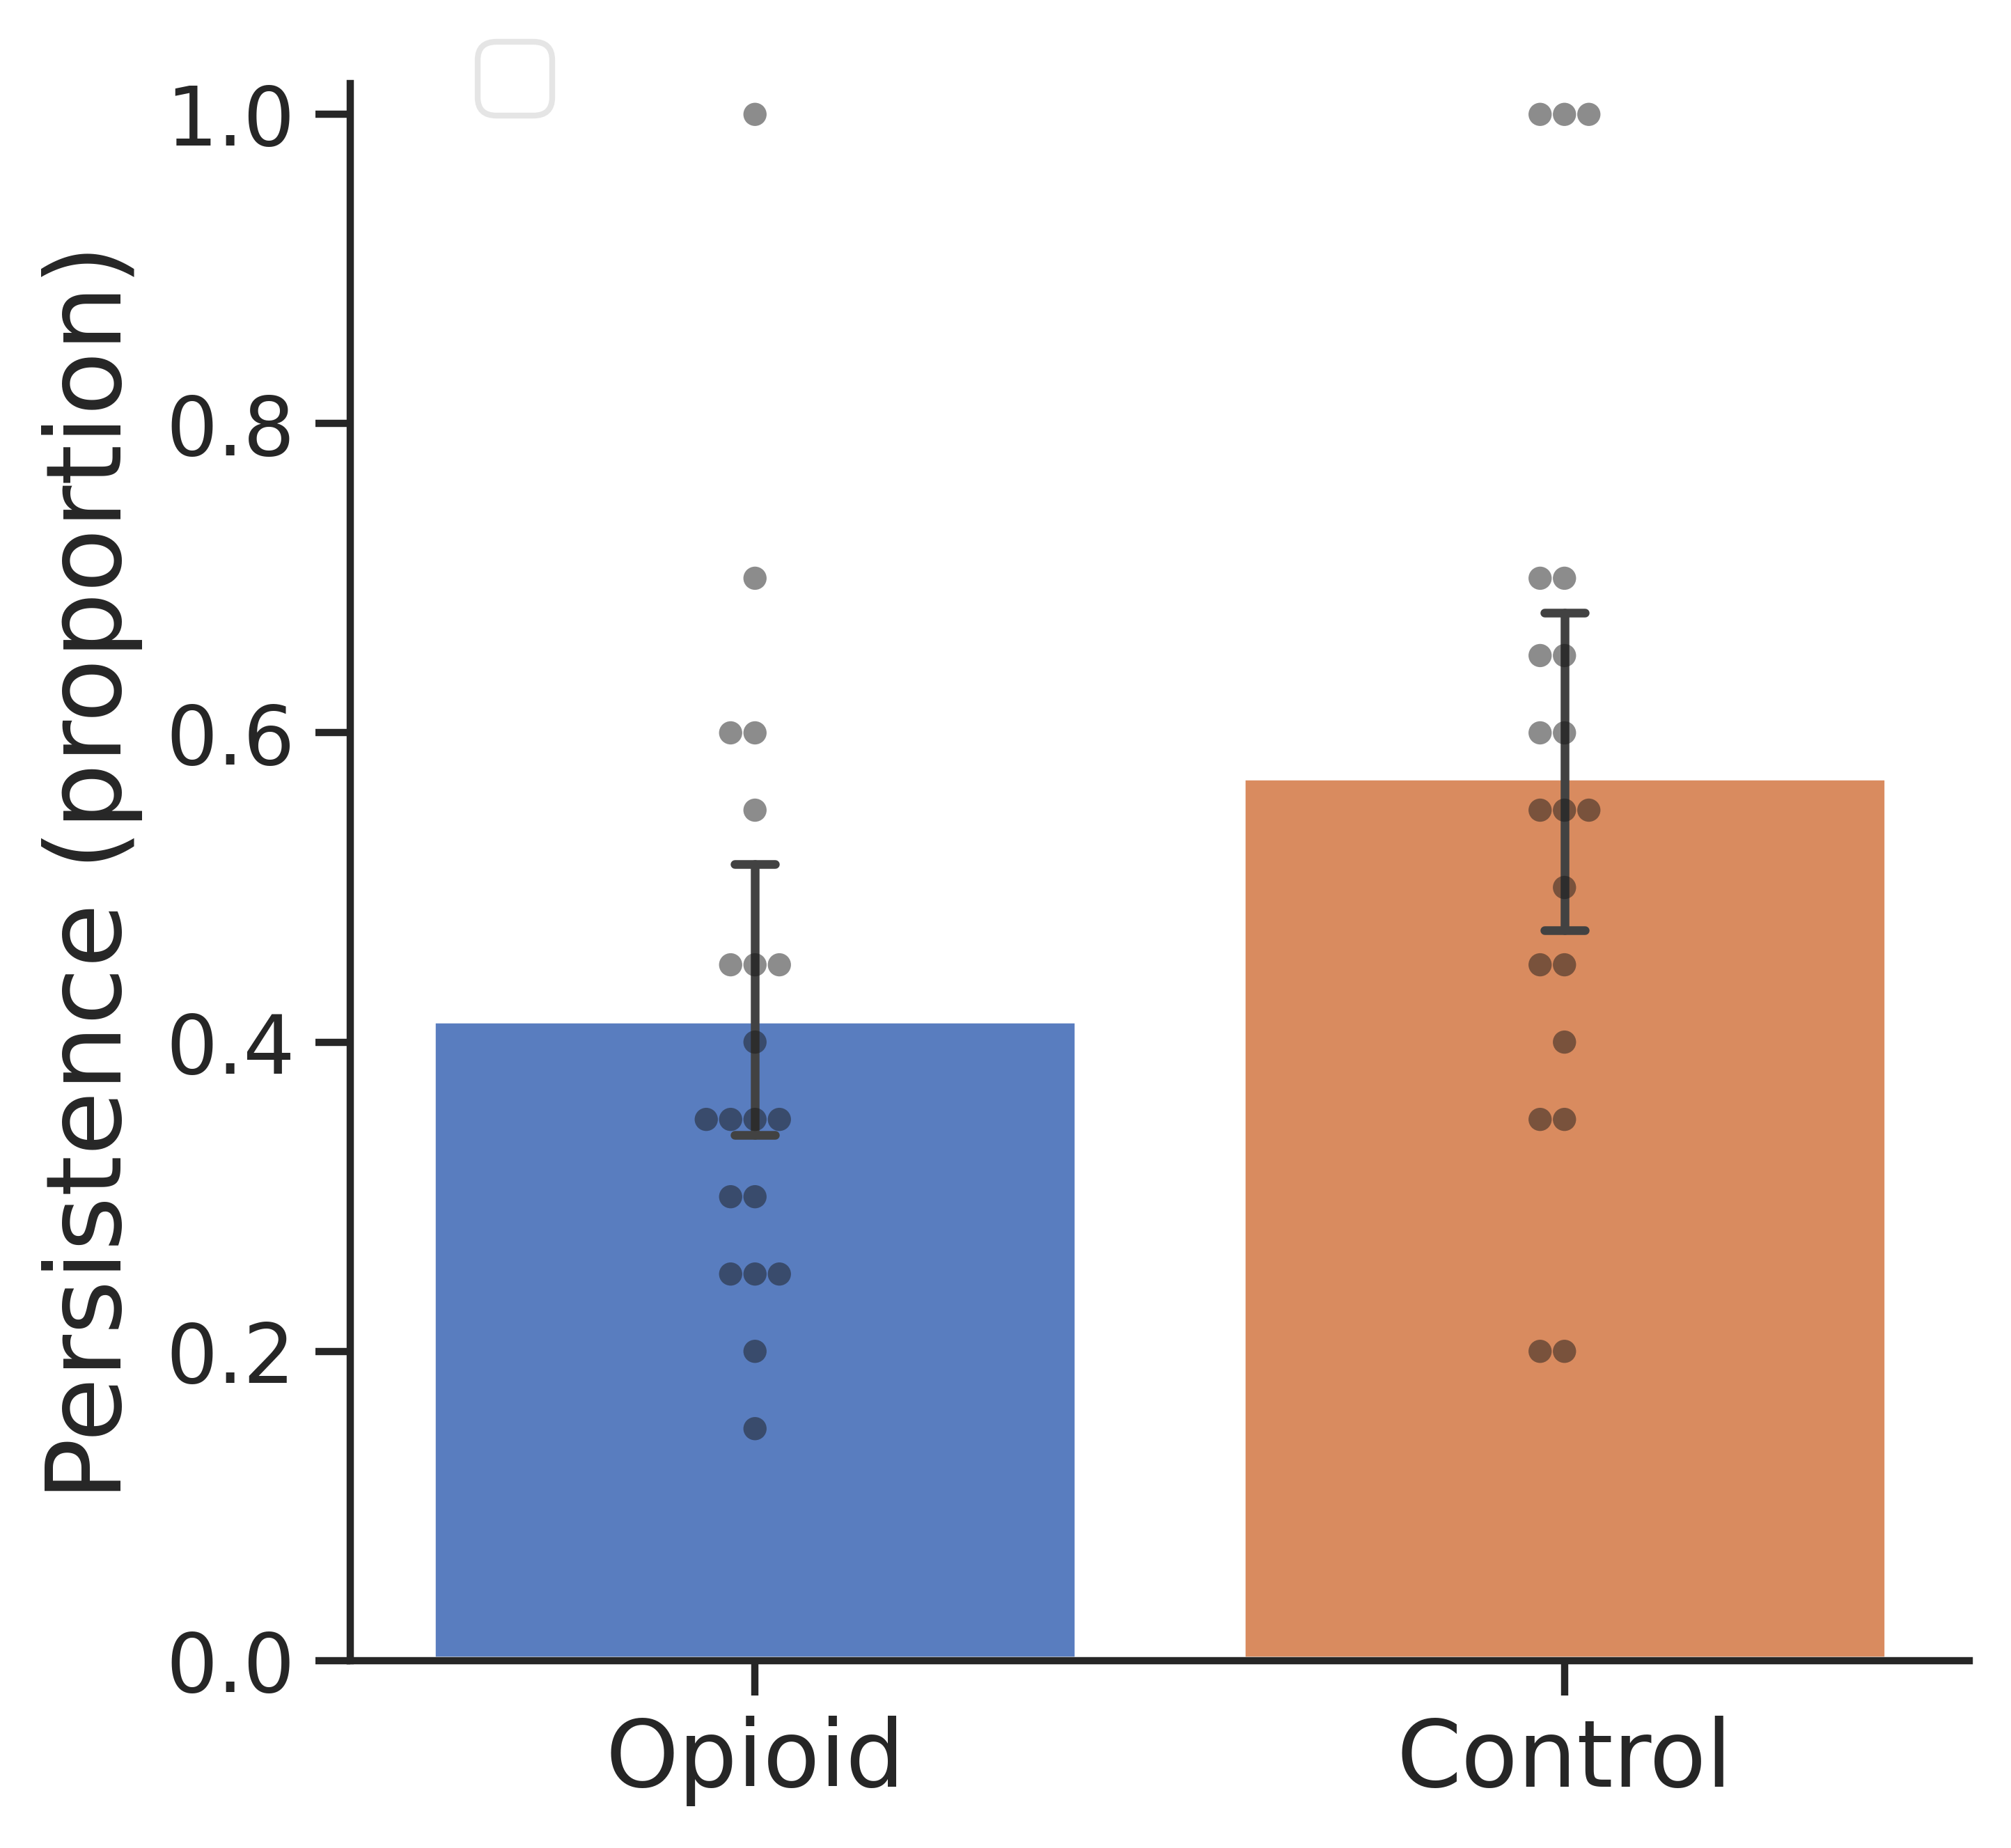

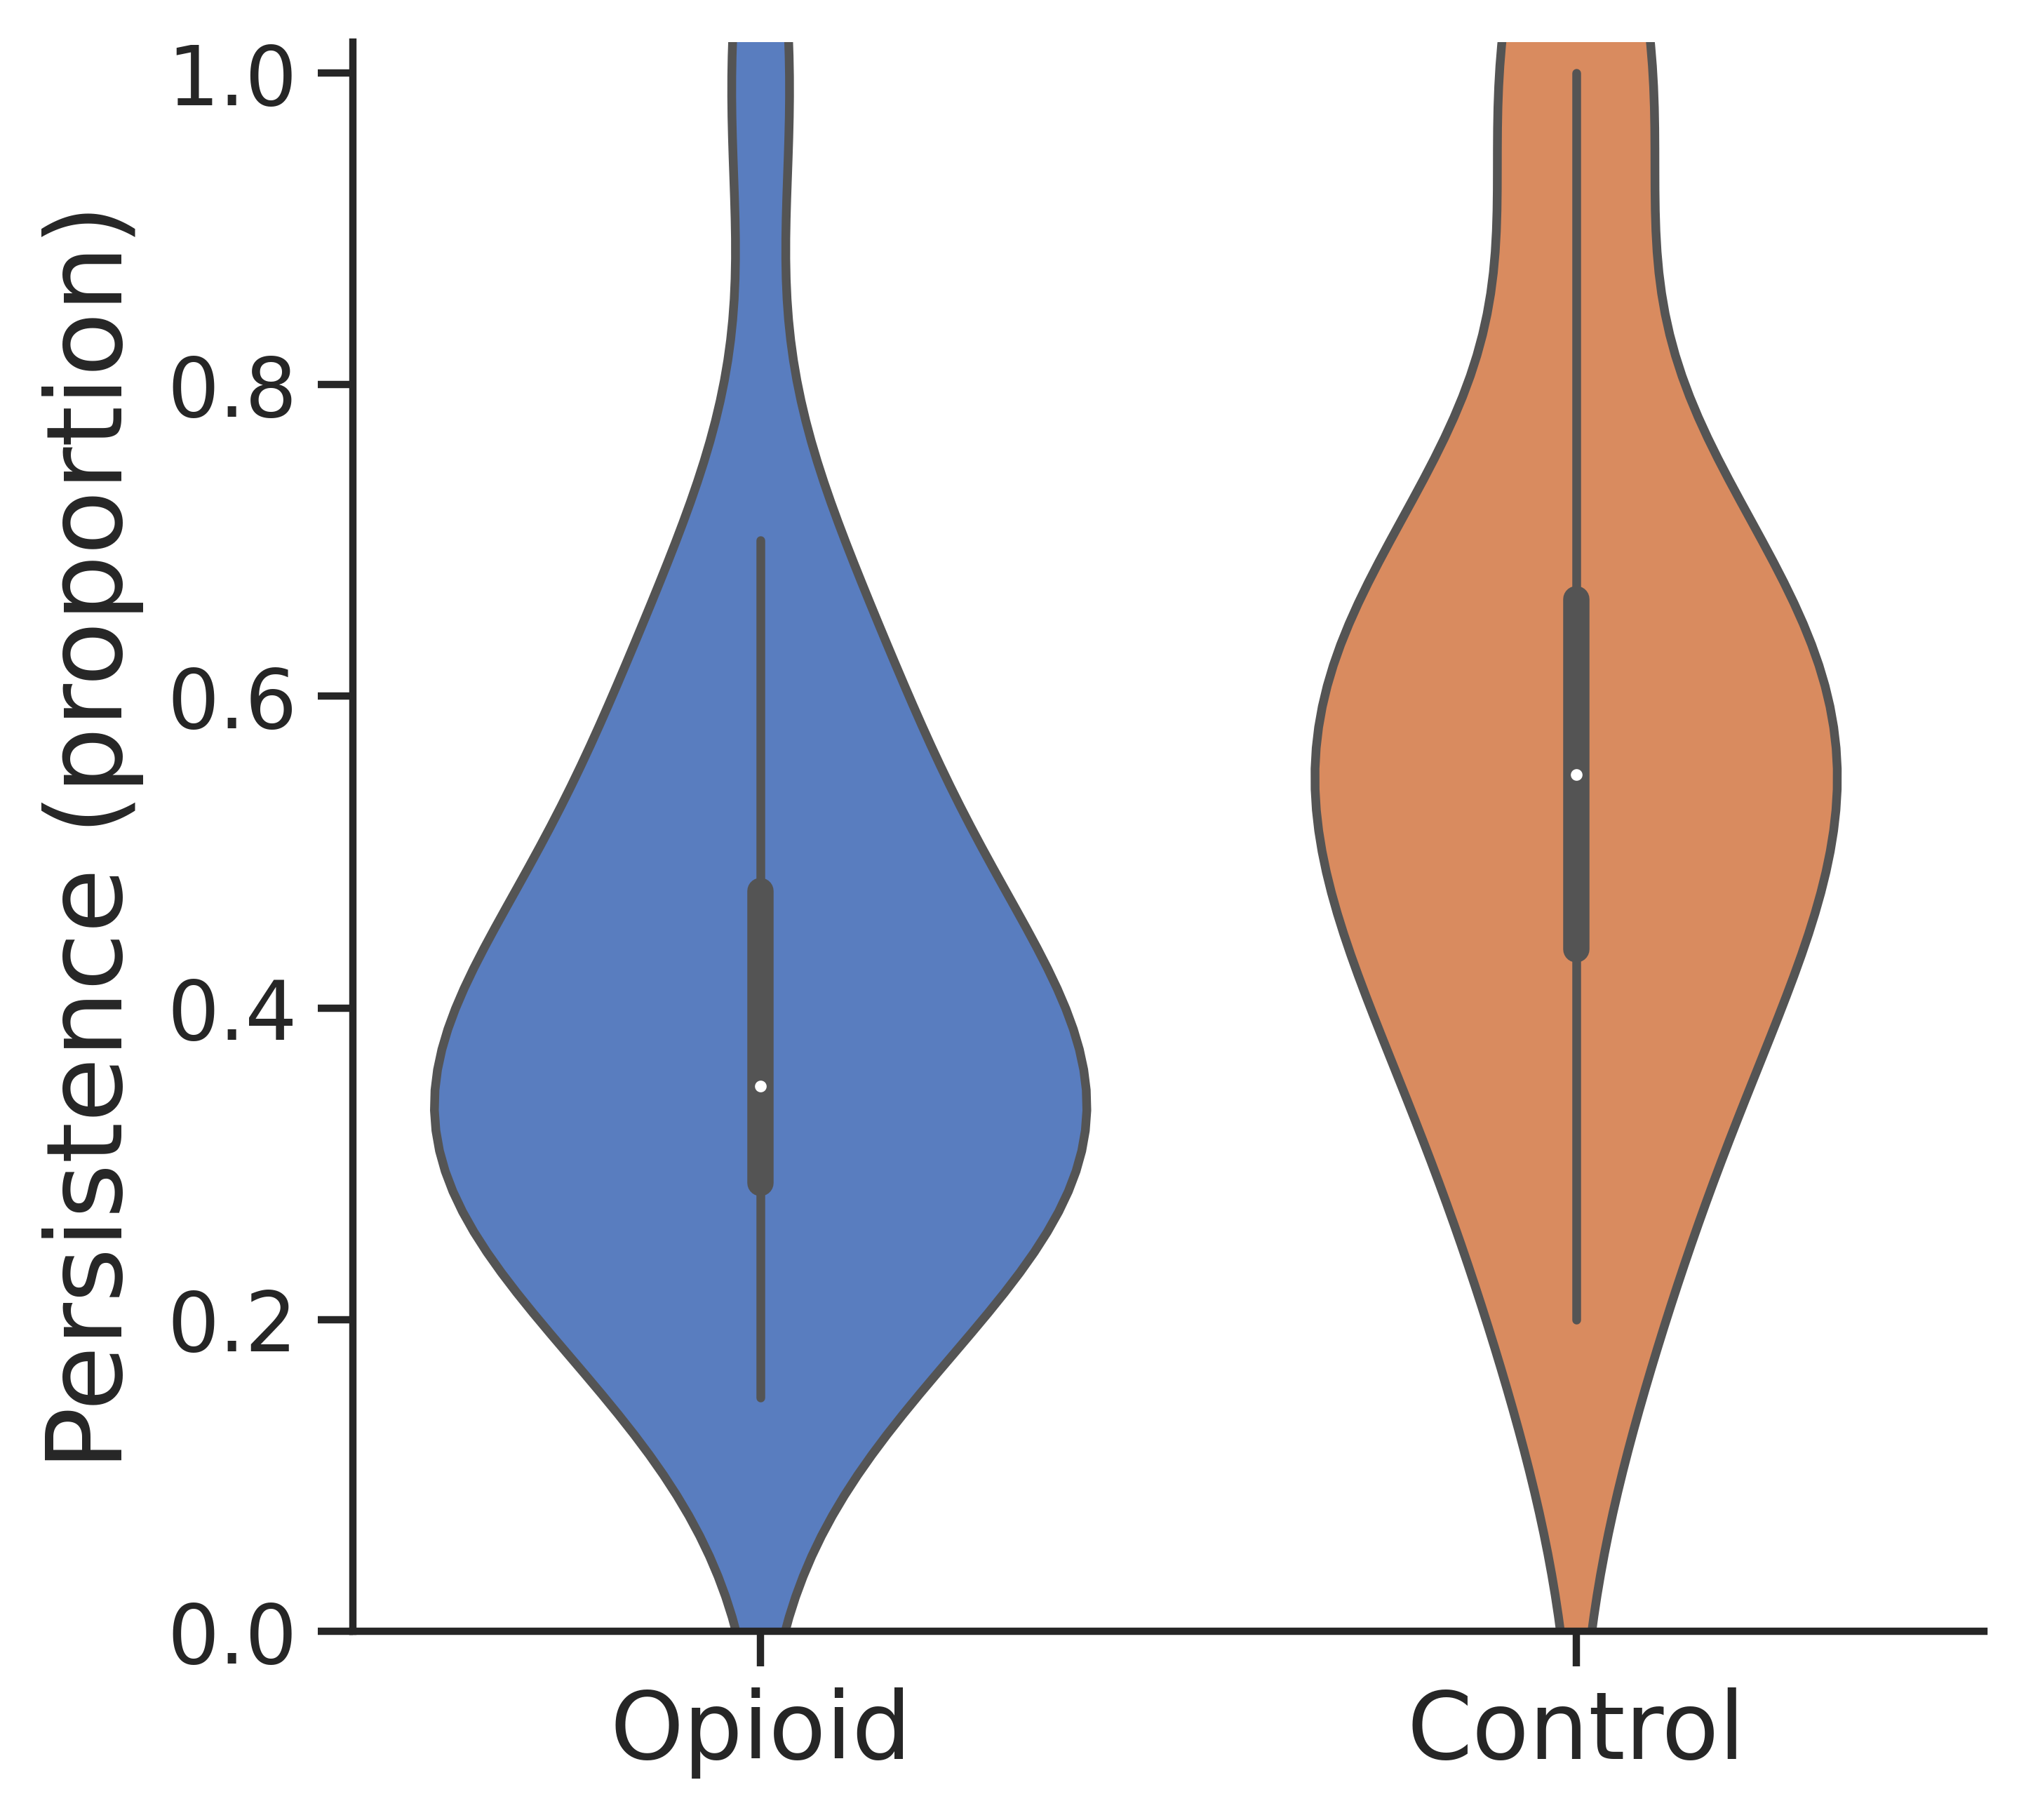

In [5]:
# behavior plots
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rcParams['figure.dpi']= 600

sns.set(font_scale=1)
sns.set(rc={"font.size":18,"axes.titlesize":18,"axes.labelsize":18})
sns.set_style("white")
sns.set_style("ticks")
sns.set_palette("muted") 

fig, axarr = plt.subplots(nrows=1, ncols=1, sharey=False, sharex=False)
fig.set_figheight(5)
fig.set_figwidth(5)
ax=axarr #[0,0]
sns.barplot(x="group", y="persist_percent", data=restruct_behav_df, ax=ax, 
            errwidth=1.5,capsize=.05, alpha=1, order=patient_group_list, **{"linewidth":1.5})
#sns.swarmplot(x="condition", y="persist_percent", hue="patientgroup", data=semistacked_behav_df, ax=ax, size = 4,
#            hue_order=patient_group_list, dodge=True, color="k", alpha=.5)
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], ['PO Use','No Use'], loc='lower left', bbox_to_anchor=(.05, .95), 
#           frameon=True, framealpha=.5, prop={'size': 16})
#ax.set_xticklabels(["PO Use", "No Use"])
ax.set_xlabel("")
ax.set_ylabel("Persistence (proportion)")
ax.set_ylim([0,1.02])
ax.tick_params(axis='x',labelsize=16)
ax.tick_params(axis='y',labelsize=14)
sns.despine()
fig.savefig("uncconcollapsedpersistence_behave.jpg", bbox_inches="tight")

fig, axarr = plt.subplots(nrows=1, ncols=1, sharey=False, sharex=False)
fig.set_figheight(5)
fig.set_figwidth(5)
ax=axarr #[0,0]
sns.barplot(x="group", y="persist_percent", data=restruct_behav_df, ax=ax, 
            errwidth=1.5,capsize=.05, alpha=1, order=patient_group_list, **{"linewidth":1.5})
sns.swarmplot(x="group", y="persist_percent", data=restruct_behav_df, ax=ax, size = 4,
           order=patient_group_list, color="k", alpha=.5)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], patient_group_list, loc='lower left', bbox_to_anchor=(.05, .95), 
          frameon=True, framealpha=.5, prop={'size': 16})
ax.set_xticklabels(patient_group_list)
ax.set_xlabel("")
ax.set_ylabel("Persistence (proportion)")
ax.set_ylim([0,1.02])
ax.tick_params(axis='x',labelsize=16)
ax.tick_params(axis='y',labelsize=14)
sns.despine()
fig.savefig("uncconcollapsedpersistence_behave_points.jpg", bbox_inches="tight")

fig, axarr = plt.subplots(nrows=1, ncols=1, sharey=False, sharex=False)
fig.set_figheight(5)
fig.set_figwidth(5)
ax=axarr #[0,0]
sns.violinplot(x="group", y="persist_percent", data=restruct_behav_df, ax=ax, 
            errwidth=1.5,capsize=.05, alpha=1, order=patient_group_list, **{"linewidth":1.5})
# sns.swarmplot(x="group", y="persist_percent", data=restruct_behav_df, ax=ax, size = 4,
#            order=patient_group_list, color="k", alpha=.5)
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[:2], patient_group_list, loc='lower left', bbox_to_anchor=(.05, .95), 
#           frameon=True, framealpha=.5, prop={'size': 16})
ax.set_xticklabels(patient_group_list)
ax.set_xlabel("")
ax.set_ylabel("Persistence (proportion)")
ax.set_ylim([0,1.02])
ax.tick_params(axis='x',labelsize=16)
ax.tick_params(axis='y',labelsize=14)
sns.despine()
fig.savefig("uncconcollapsedpersistence_behave_violin.jpg", bbox_inches="tight")

sns.despine()

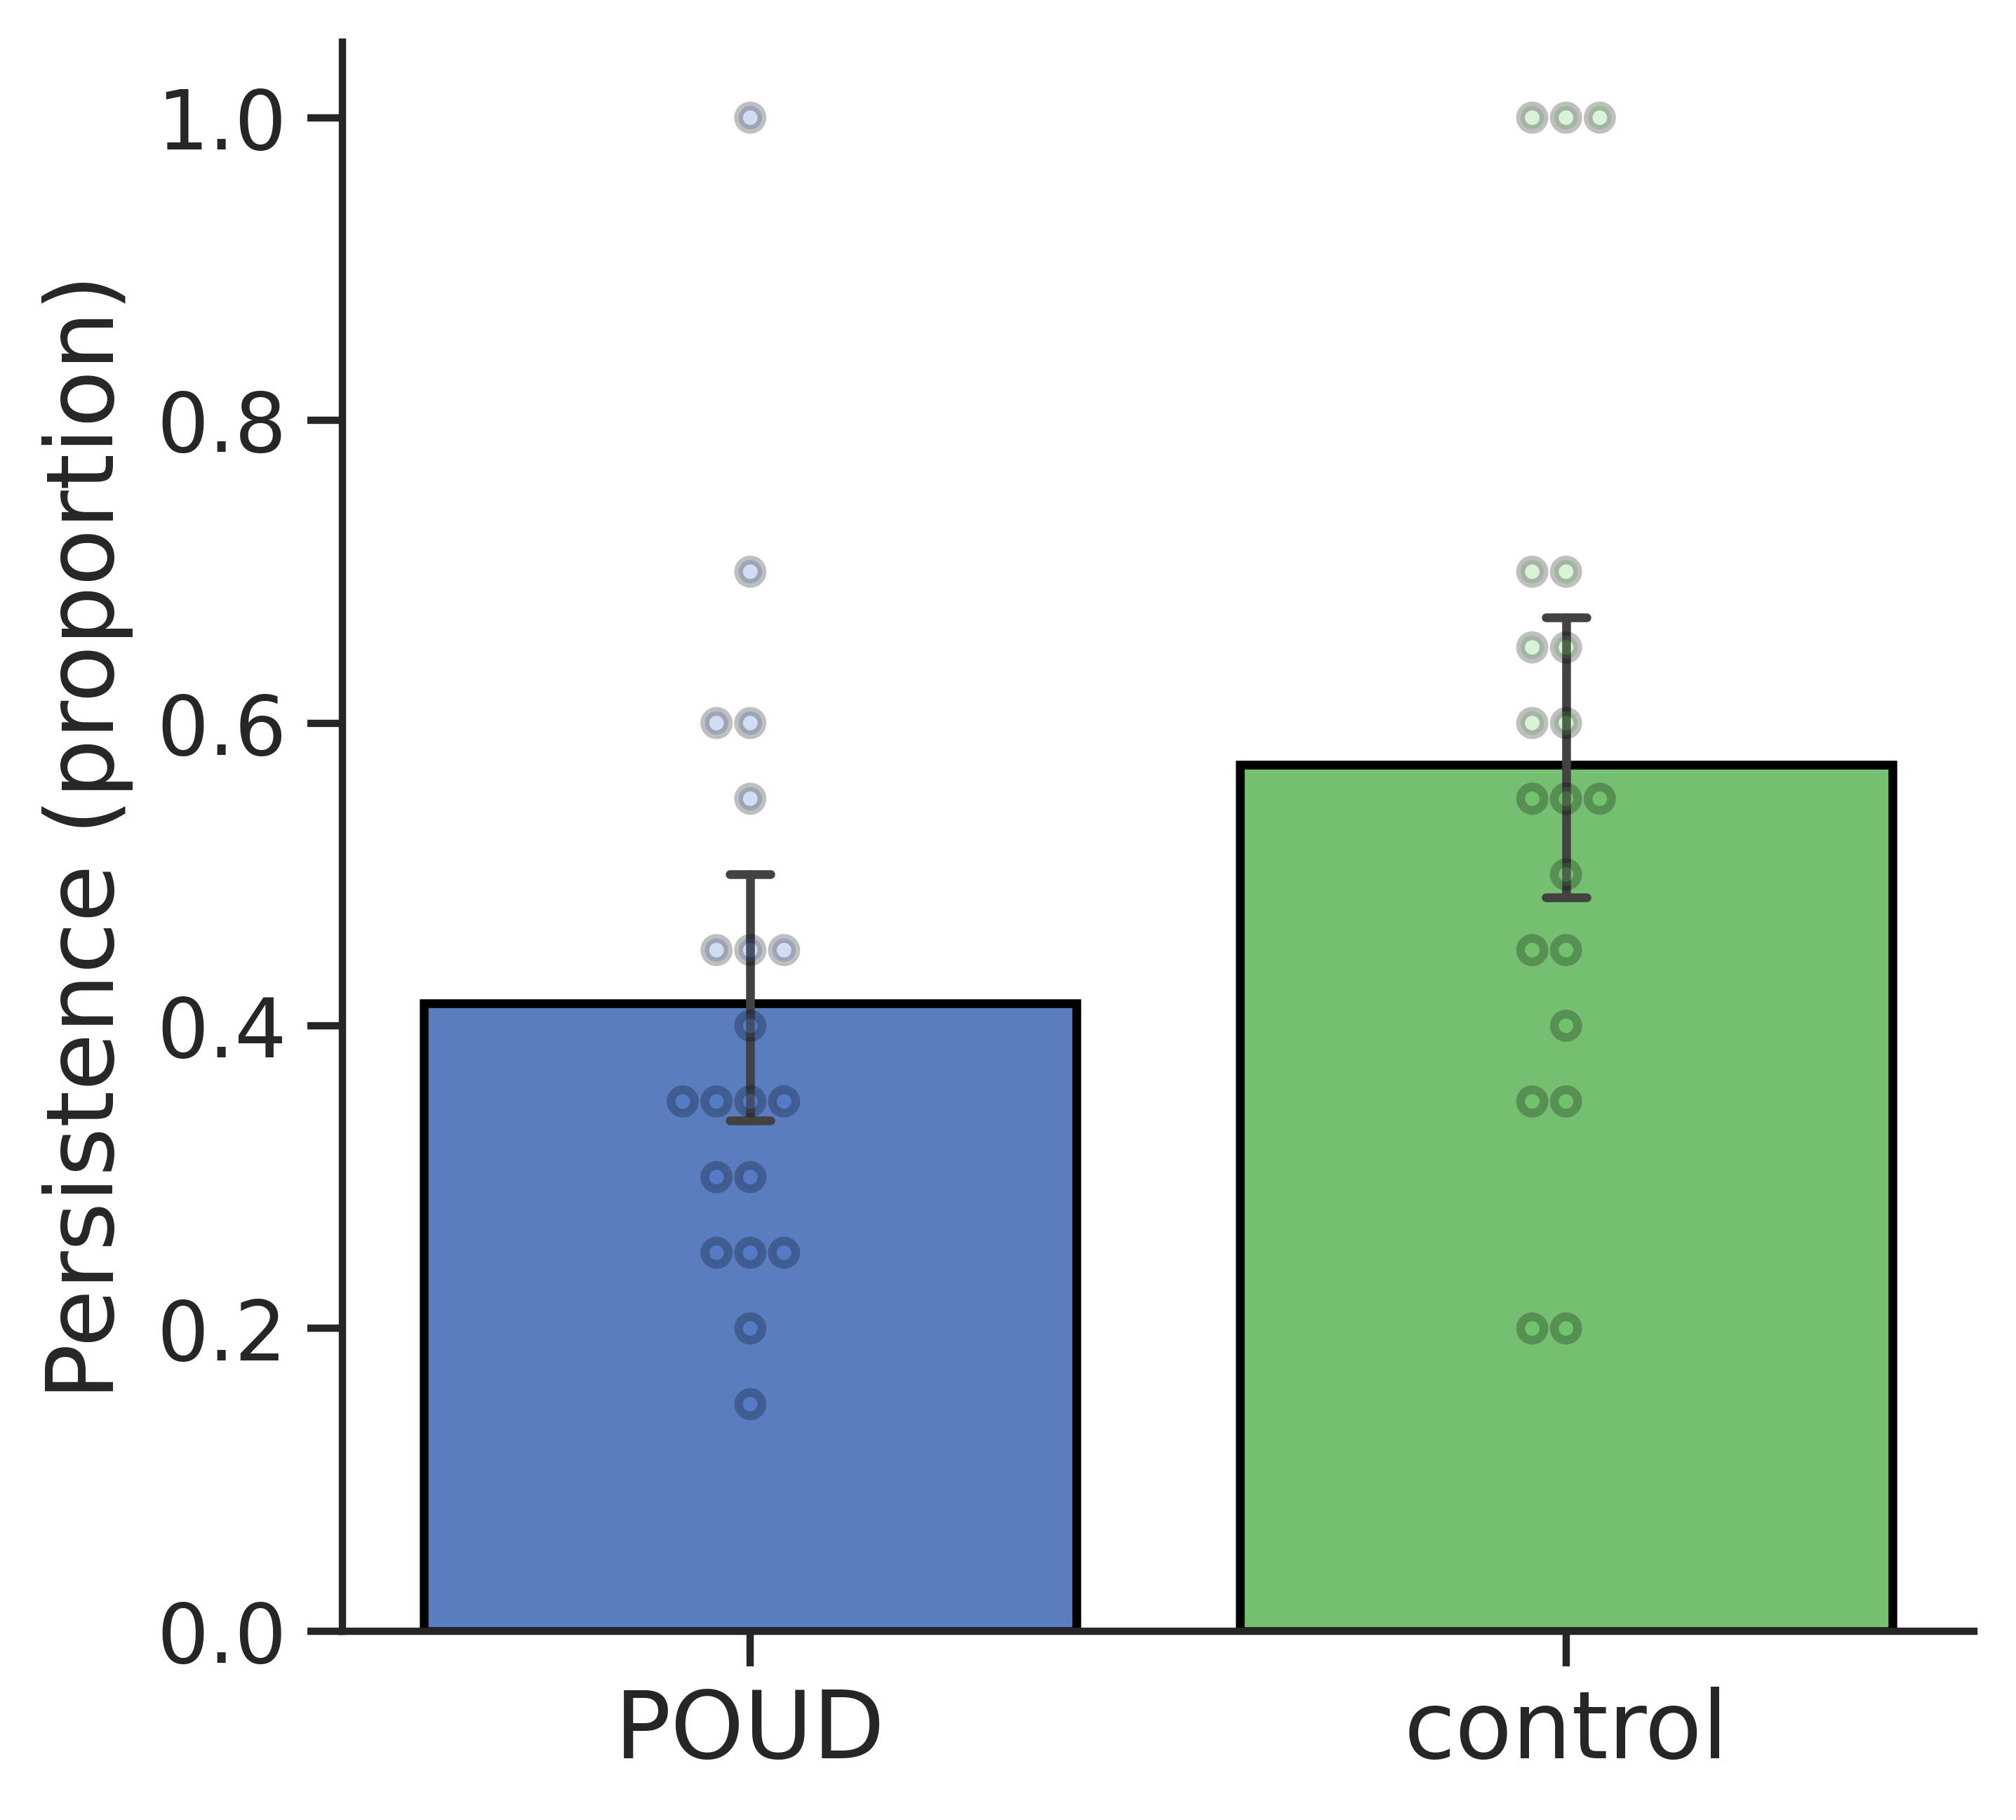

In [6]:
# different look for persistence bar chart
fig,ax = plt.subplots(nrows=1, ncols=1)
fig.set_figwidth(5)
fig.set_figheight(5)
sns.barplot(x="group", y="persist_percent", data=restruct_behav_df, ax=ax, palette = palette2col,
                 errwidth=1.5,capsize=.05, alpha=1, order=patient_group_list,**{"edgecolor":"black", "linewidth":1.5})
sns.swarmplot(x="group", y="persist_percent", data=restruct_behav_df, ax=ax, size = 4, palette = palette2col,
                 alpha=0.25, order=patient_group_list,**{"edgecolor":"black", "linewidth":1.5})
#ax.set_title(emo)
# handles, labels = ax.get_legend_handles_labels()
# ax.legend(handles[2:], ['PO Use','No Use'], loc='lower left', bbox_to_anchor=(.05, .95), 
#           frameon=True, framealpha=.5, prop={'size': 16})
ax.set_ylabel("Persistence (proportion)", fontsize = 16)
ax.set_xlabel("")
ax.set_xticklabels(['POUD','control'],fontsize = 16)
ax.set_ylim([0,1.05])
ax.tick_params(axis='y',labelsize=14)
sns.despine()
fig.savefig("unccon_persist_w_points.jpg", bbox_inches="tight", dpi=600)

## group comparisons

### Behavior
- predicted effect of lower persistence on same path in Opioid group
- no RT effects

In [7]:
# t-tests
from scipy import stats
from numpy import std, mean, sqrt
from mlxtend.evaluate import permutation_test

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)

restruct_behav_df['persistApercentofopps'] = restruct_behav_df['persistAsum']/restruct_behav_df['persistAopps']
restruct_behav_df['persistBpercentofopps'] = restruct_behav_df['persistBsum'].div(restruct_behav_df['persistBopps'].replace(0, np.nan))
restruct_behav_df['persistCpercentofopps'] = restruct_behav_df['persistCsum'].div(restruct_behav_df['persistCopps'].replace(0, np.nan))


DV='persist_percent'
x = restruct_behav_df.loc[restruct_behav_df['group']==patient_group_list[0],DV]
y = restruct_behav_df.loc[restruct_behav_df['group']==patient_group_list[1],DV]
std_xy = sqrt(((x.shape[0] - 1)*(x.std())**2 + (y.shape[0] - 1)*(y.std())**2) / (x.shape[0]+y.shape[0]-2) )
MoE = stats.t.ppf([0.975], x.shape[0]+y.shape[0]-2) * std_xy * sqrt(1/x.shape[0] + 1/y.shape[0] )
mdiff = np.mean(y)-np.mean(x)
t,p = stats.ttest_ind(y,x)
pperm = permutation_test(x.values, y.values,func= lambda x, y: abs(np.mean(y)-np.mean(x)),method='approximate',seed=0,num_rounds=100000)
d = cohen_d(x,y)
print ('Ctl-Opioid Persistence: mdiff=%.4f, CI=[%.4f,%.4f], t= %.4f, p= %.4f, pperm=%.4f, d = %.4f' % (mdiff,mdiff-MoE,mdiff+MoE,t,p,pperm,d))

DV='switch_percent'
x = restruct_behav_df.loc[restruct_behav_df['group']==patient_group_list[0],DV]
y = restruct_behav_df.loc[restruct_behav_df['group']==patient_group_list[1],DV]
std_xy = sqrt(((x.shape[0] - 1)*(x.std())**2 + (y.shape[0] - 1)*(y.std())**2) / (x.shape[0]+y.shape[0]-2) )
MoE = stats.t.ppf([0.975], x.shape[0]+y.shape[0]-2) * std_xy * sqrt(1/x.shape[0] + 1/y.shape[0] )
mdiff = np.mean(y)-np.mean(x)
t,p = stats.ttest_ind(y.dropna(),x.dropna())
pperm = permutation_test(x.dropna().values, y.dropna().values,func= lambda x, y: abs(np.mean(y)-np.mean(x)),method='approximate',seed=0,num_rounds=100000)
d = cohen_d(x,y)
print ('Switches to lower value path: CTL=%.4f(%.4f), Opioid=%.4f(%.4f), mdiff=%.4f, CI=[%.4f,%.4f], t= %.4f, p= %.4f, pperm=%.4f, d = %.4f' % 
       (np.mean(y),np.std(y),np.mean(x),np.std(x),mdiff,mdiff-MoE,mdiff+MoE,t,p,pperm,d))

DV='path_response_time'
x = restruct_behav_df.loc[restruct_behav_df['group']==patient_group_list[0],DV]
y = restruct_behav_df.loc[restruct_behav_df['group']==patient_group_list[1],DV]
std_xy = sqrt(((x.shape[0] - 1)*(x.std())**2 + (y.shape[0] - 1)*(y.std())**2) / (x.shape[0]+y.shape[0]-2) )
MoE = stats.t.ppf([0.975], x.shape[0]+y.shape[0]-2) * std_xy * sqrt(1/x.shape[0] + 1/y.shape[0] )
mdiff = np.mean(y)-np.mean(x)
t,p = stats.ttest_ind(y,x)
pperm = permutation_test(x.values, y.values,func= lambda x, y: abs(np.mean(y)-np.mean(x)),method='approximate',seed=0,num_rounds=100000)
d = cohen_d(x,y)
print ('Ctl-Opioid Pathchoice RT: mdiff=%.4f, CI=[%.4f,%.4f], t= %.4f, p= %.4f, pperm=%.4f, d = %.4f' % (mdiff,mdiff-MoE,mdiff+MoE,t,p,pperm,d))

DV='cue_response_time'
x = restruct_behav_df.loc[restruct_behav_df['group']==patient_group_list[0],DV]
y = restruct_behav_df.loc[restruct_behav_df['group']==patient_group_list[1],DV]
std_xy = sqrt(((x.shape[0] - 1)*(x.std())**2 + (y.shape[0] - 1)*(y.std())**2) / (x.shape[0]+y.shape[0]-2) )
MoE = stats.t.ppf([0.975], x.shape[0]+y.shape[0]-2) * std_xy * sqrt(1/x.shape[0] + 1/y.shape[0] )
mdiff = np.mean(y)-np.mean(x)
t,p = stats.ttest_ind(y,x)
pperm = permutation_test(x.values, y.values,func= lambda x, y: abs(np.mean(y)-np.mean(x)),method='approximate',seed=0,num_rounds=100000)
d = cohen_d(x,y)
print ('Ctl-Opioid cue RT: mdiff=%.4f, CI=[%.4f,%.4f], t= %.4f, p= %.4f, pperm=%.4f, d = %.4f' % (mdiff,mdiff-MoE,mdiff+MoE,t,p,pperm,d))

DV='firstchoiceA'
x = restruct_behav_df.loc[restruct_behav_df['group']==patient_group_list[0],DV]/10
y = restruct_behav_df.loc[restruct_behav_df['group']==patient_group_list[1],DV]/10
std_xy = sqrt(((x.shape[0] - 1)*(x.std())**2 + (y.shape[0] - 1)*(y.std())**2) / (x.shape[0]+y.shape[0]-2) )
MoE = stats.t.ppf([0.975], x.shape[0]+y.shape[0]-2) * std_xy * sqrt(1/x.shape[0] + 1/y.shape[0] )
mdiff = np.mean(y)-np.mean(x)
t,p = stats.ttest_ind(y,x)
pperm = permutation_test(x.values, y.values,func= lambda x, y: abs(np.mean(y)-np.mean(x)),method='approximate',seed=0,num_rounds=100000)
d = cohen_d(x,y)
print ('Ctl-Opioid firstchoice path A: CTL=%.4f(%.4f), Opioid=%.4f(%.4f), mdiff=%.4f, CI=[%.4f,%.4f], t= %.4f, p= %.4f, pperm=%.4f, d = %.4f' % 
       (np.mean(y),np.std(y),np.mean(x),np.std(x),mdiff,mdiff-MoE,mdiff+MoE,t,p,pperm,d))

DV='firstchoiceB'
x = restruct_behav_df.loc[restruct_behav_df['group']==patient_group_list[0],DV]/10
y = restruct_behav_df.loc[restruct_behav_df['group']==patient_group_list[1],DV]/10
std_xy = sqrt(((x.shape[0] - 1)*(x.std())**2 + (y.shape[0] - 1)*(y.std())**2) / (x.shape[0]+y.shape[0]-2) )
MoE = stats.t.ppf([0.975], x.shape[0]+y.shape[0]-2) * std_xy * sqrt(1/x.shape[0] + 1/y.shape[0] )
mdiff = np.mean(y)-np.mean(x)
t,p = stats.ttest_ind(y,x)
pperm = permutation_test(x.values, y.values,func= lambda x, y: abs(np.mean(y)-np.mean(x)),method='approximate',seed=0,num_rounds=100000)
d = cohen_d(x,y)
print ('Ctl-Opioid firstchoice path B: CTL=%.4f(%.4f), Opioid=%.4f(%.4f), mdiff=%.4f, CI=[%.4f,%.4f], t= %.4f, p= %.4f, pperm=%.4f, d = %.4f' % 
       (np.mean(y),np.std(y),np.mean(x),np.std(x),mdiff,mdiff-MoE,mdiff+MoE,t,p,pperm,d))

DV='firstchoiceC'
x = restruct_behav_df.loc[restruct_behav_df['group']==patient_group_list[0],DV]/10
y = restruct_behav_df.loc[restruct_behav_df['group']==patient_group_list[1],DV]/10
std_xy = sqrt(((x.shape[0] - 1)*(x.std())**2 + (y.shape[0] - 1)*(y.std())**2) / (x.shape[0]+y.shape[0]-2) )
MoE = stats.t.ppf([0.975], x.shape[0]+y.shape[0]-2) * std_xy * sqrt(1/x.shape[0] + 1/y.shape[0] )
mdiff = np.mean(y)-np.mean(x)
t,p = stats.ttest_ind(y,x)
pperm = permutation_test(x.values, y.values,func= lambda x, y: abs(np.mean(y)-np.mean(x)),method='approximate',seed=0,num_rounds=100000)
d = cohen_d(x,y)
print ('Ctl-Opioid firstchoice path C: CTL=%.4f(%.4f), Opioid=%.4f(%.4f), mdiff=%.4f, CI=[%.4f,%.4f], t= %.4f, p= %.4f, pperm=%.4f, d = %.4f' % 
       (np.mean(y),np.std(y),np.mean(x),np.std(x),mdiff,mdiff-MoE,mdiff+MoE,t,p,pperm,d))

DV='persistApercentofopps'
x = restruct_behav_df.loc[restruct_behav_df['group']==patient_group_list[0],DV]
y = restruct_behav_df.loc[restruct_behav_df['group']==patient_group_list[1],DV]
std_xy = sqrt(((x.shape[0] - 1)*(x.std())**2 + (y.shape[0] - 1)*(y.std())**2) / (x.shape[0]+y.shape[0]-2) )
MoE = stats.t.ppf([0.975], x.shape[0]+y.shape[0]-2) * std_xy * sqrt(1/x.shape[0] + 1/y.shape[0] )
mdiff = np.mean(y)-np.mean(x)
t,p = stats.ttest_ind(y,x)
pperm = permutation_test(x.values, y.values,func= lambda x, y: abs(np.mean(y)-np.mean(x)),method='approximate',seed=0,num_rounds=100000)
d = cohen_d(x,y)
print ('Ctl-Opioid path A persist perc: CTL=%.4f(%.4f), Opioid=%.4f(%.4f), mdiff=%.4f, CI=[%.4f,%.4f], t= %.4f, p= %.4f, pperm=%.4f, d = %.4f' % 
       (np.mean(y),np.std(y),np.mean(x),np.std(x),mdiff,mdiff-MoE,mdiff+MoE,t,p,pperm,d))

DV='pathAchoices'
x = restruct_behav_df.loc[restruct_behav_df['group']==patient_group_list[0],DV]
y = restruct_behav_df.loc[restruct_behav_df['group']==patient_group_list[1],DV]
std_xy = sqrt(((x.shape[0] - 1)*(x.std())**2 + (y.shape[0] - 1)*(y.std())**2) / (x.shape[0]+y.shape[0]-2) )
MoE = stats.t.ppf([0.975], x.shape[0]+y.shape[0]-2) * std_xy * sqrt(1/x.shape[0] + 1/y.shape[0] )
mdiff = np.mean(y)-np.mean(x)
t,p = stats.ttest_ind(y,x)
pperm = permutation_test(x.values, y.values,func= lambda x, y: abs(np.mean(y)-np.mean(x)),method='approximate',seed=0,num_rounds=100000)
d = cohen_d(x,y)
print ('Ctl-Opioid path A choices (persist or not): CTL=%.4f(%.4f), Opioid=%.4f(%.4f), mdiff=%.4f, CI=[%.4f,%.4f], t= %.4f, p= %.4f, pperm=%.4f, d = %.4f' % 
       (np.mean(y),np.std(y),np.mean(x),np.std(x),mdiff,mdiff-MoE,mdiff+MoE,t,p,pperm,d))

DV='persistBpercentofopps'
x = restruct_behav_df.loc[restruct_behav_df['group']==patient_group_list[0],DV]
y = restruct_behav_df.loc[restruct_behav_df['group']==patient_group_list[1],DV]
std_xy = sqrt(((x.shape[0] - 1)*(x.std())**2 + (y.shape[0] - 1)*(y.std())**2) / (x.shape[0]+y.shape[0]-2) )
MoE = stats.t.ppf([0.975], x.shape[0]+y.shape[0]-2) * std_xy * sqrt(1/x.shape[0] + 1/y.shape[0] )
mdiff = np.mean(y)-np.mean(x)
t,p = stats.ttest_ind(y.dropna(),x.dropna())
pperm = permutation_test(x.dropna().values, y.dropna().values,func= lambda x, y: abs(np.mean(y)-np.mean(x)),method='approximate',seed=0,num_rounds=100000)
d = cohen_d(x,y)
print ('Ctl-Opioid path B persistence: CTL=%.4f(%.4f), Opioid=%.4f(%.4f), mdiff=%.4f, CI=[%.4f,%.4f], t= %.4f, p= %.4f, pperm=%.4f, d = %.4f' % 
       (np.mean(y),np.std(y),np.mean(x),np.std(x),mdiff,mdiff-MoE,mdiff+MoE,t,p,pperm,d))

DV='persistCpercentofopps'
x = restruct_behav_df.loc[restruct_behav_df['group']==patient_group_list[0],DV]
y = restruct_behav_df.loc[restruct_behav_df['group']==patient_group_list[1],DV]
std_xy = sqrt(((x.shape[0] - 1)*(x.std())**2 + (y.shape[0] - 1)*(y.std())**2) / (x.shape[0]+y.shape[0]-2) )
MoE = stats.t.ppf([0.975], x.shape[0]+y.shape[0]-2) * std_xy * sqrt(1/x.shape[0] + 1/y.shape[0] )
mdiff = np.mean(y)-np.mean(x)
t,p = stats.ttest_ind(y.dropna(),x.dropna())
pperm = permutation_test(x.dropna().values, y.dropna().values,func= lambda x, y: abs(np.mean(y)-np.mean(x)),method='approximate',seed=0,num_rounds=100000)
d = cohen_d(x,y)
print ('Ctl-Opioid path C persistence: CTL=%.4f(%.4f), Opioid=%.4f(%.4f), mdiff=%.4f, CI=[%.4f,%.4f], t= %.4f, p= %.4f, pperm=%.4f, d = %.4f' % 
       (np.mean(y),np.std(y),np.mean(x),np.std(x),mdiff,mdiff-MoE,mdiff+MoE,t,p,pperm,d))





Ctl-Opioid Persistence: mdiff=0.1575, CI=[0.0184,0.2966], t= 2.2930, p= 0.0275, pperm=0.0270, d = -0.7251
Switches to lower value path: CTL=0.2150(0.1236), Opioid=0.2950(0.1161), mdiff=-0.0800, CI=[-0.1587,-0.0013], t= -2.0566, p= 0.0466, pperm=0.0471, d = 0.6504
Ctl-Opioid Pathchoice RT: mdiff=0.0120, CI=[-0.1316,0.1557], t= 0.1696, p= 0.8662, pperm=0.8671, d = -0.0536
Ctl-Opioid cue RT: mdiff=-0.0128, CI=[-0.1400,0.1144], t= -0.2040, p= 0.8395, pperm=0.8401, d = 0.0645
Ctl-Opioid firstchoice path A: CTL=0.6200(0.2522), Opioid=0.5700(0.2968), mdiff=0.0500, CI=[-0.1309,0.2309], t= 0.5596, p= 0.5791, pperm=0.5464, d = -0.1770
Ctl-Opioid firstchoice path B: CTL=0.2300(0.1873), Opioid=0.2150(0.1931), mdiff=0.0150, CI=[-0.1099,0.1399], t= 0.2430, p= 0.8093, pperm=0.8134, d = -0.0769
Ctl-Opioid firstchoice path C: CTL=0.1500(0.1204), Opioid=0.2150(0.1878), mdiff=-0.0650, CI=[-0.1686,0.0386], t= -1.2699, p= 0.2118, pperm=0.1772, d = 0.4016
Ctl-Opioid path A persist perc: CTL=0.6703(0.3565), 

In [8]:
restruct_behav_df.loc[restruct_behav_df['group']==patient_group_list[1],'persistCpercentofopps']


20    0.500000
21    0.428571
22    0.000000
23    1.000000
24         NaN
25    0.000000
26    0.000000
27         NaN
28    0.333333
29         NaN
30    0.500000
31    0.000000
32    0.000000
33    0.000000
34    0.000000
35    0.714286
36    0.000000
37    0.500000
38    0.500000
39    0.500000
Name: persistCpercentofopps, dtype: float64

In [10]:
smoker_data = pd.read_csv("Smoking data.csv")
temp = restruct_behav_df
temp.subject = temp.subject.astype(int)
sm_restruct_behav_df = pd.merge(temp, smoker_data, left_on='subject', right_on='Subject')
sm_restruct_behav_df['groupbool'] = (sm_restruct_behav_df['group'] == 'Opioid').astype(int)
temp = sm_restruct_behav_df[['persist_percent','groupbool','CigaretteQuantity']].astype(float)
temp.dtypes

persist_percent      float64
groupbool            float64
CigaretteQuantity    float64
dtype: object

In [11]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
groupanc = sm.RLM(sm_restruct_behav_df['persist_percent'],sm.add_constant(sm_restruct_behav_df[['groupbool','CigaretteQuantity']]),M=sm.robust.norms.HuberT()).fit()
groupanc.tvalues['groupbool']

-1.4787293389192186

In [12]:
# t-tests w smoking frequency covariate
from scipy import stats
from numpy import std, mean, sqrt
from mlxtend.evaluate import permutation_test

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)

DV='persist_percent'
x = sm_restruct_behav_df.loc[sm_restruct_behav_df['group']==patient_group_list[0],DV]
y = sm_restruct_behav_df.loc[sm_restruct_behav_df['group']==patient_group_list[1],DV]
std_xy = sqrt(((x.shape[0] - 1)*(x.std())**2 + (y.shape[0] - 1)*(y.std())**2) / (x.shape[0]+y.shape[0]-2) )
MoE = stats.t.ppf([0.975], x.shape[0]+y.shape[0]-2) * std_xy * sqrt(1/x.shape[0] + 1/y.shape[0] )
mdiff = np.mean(y)-np.mean(x)
t,p = stats.ttest_ind(x,y)
pperm = permutation_test(x.values, y.values,func= lambda x, y: abs(np.mean(y)-np.mean(x)),method='approximate',seed=0,num_rounds=100000)
d = cohen_d(x,y)
print ('Ctl-Opioid Persistence: mdiff=%.4f, CI=[%.4f,%.4f], t= %.4f, p= %.4f, pperm=%.4f, d = %.4f' % (mdiff,mdiff-MoE,mdiff+MoE,t,p,pperm,d))
print('Ctl mean: %.3f (%.3f), Opioid mean: %.3f (%.3f)' %(np.mean(y), np.std(y),np.mean(x), np.std(x)))
import statsmodels.api as sm
import statsmodels.formula.api as smf
groupanc = sm.RLM(sm_restruct_behav_df['persist_percent'],sm.add_constant(sm_restruct_behav_df[['groupbool','CigaretteQuantity']]),M=sm.robust.norms.HuberT()).fit()
print ('with control for cigarettes per week: t= %.4f, p = %.4f'%(groupanc.tvalues['groupbool'], groupanc.pvalues['groupbool']))
print ('effect of cigarettes per week: t= %.4f, p = %.4f'%(groupanc.tvalues['CigaretteQuantity'], groupanc.pvalues['CigaretteQuantity']))
DV='CigaretteQuantity'
x = sm_restruct_behav_df.loc[sm_restruct_behav_df['group']==patient_group_list[0],DV]
y = sm_restruct_behav_df.loc[sm_restruct_behav_df['group']==patient_group_list[1],DV]
std_xy = sqrt(((x.shape[0] - 1)*(x.std())**2 + (y.shape[0] - 1)*(y.std())**2) / (x.shape[0]+y.shape[0]-2) )
MoE = stats.t.ppf([0.975], x.shape[0]+y.shape[0]-2) * std_xy * sqrt(1/x.shape[0] + 1/y.shape[0] )
mdiff = np.mean(y)-np.mean(x)
t,p = stats.ttest_ind(x,y)
pperm = permutation_test(x.values, y.values,func= lambda x, y: abs(np.mean(y)-np.mean(x)),method='approximate',seed=0,num_rounds=100000)
d = cohen_d(x,y)
print ('Ctl-Opioid Cigarette Smoking: mdiff=%.4f, CI=[%.4f,%.4f], t= %.4f, p= %.4f, pperm=%.4f, d = %.4f' % (mdiff,mdiff-MoE,mdiff+MoE,t,p,pperm,d))
print('Ctl mean: %.3f (%.3f), Opioid mean: %.3f (%.3f)' %(np.mean(y), np.std(y),np.mean(x), np.std(x)))


DV='path_response_time'
x = restruct_behav_df.loc[restruct_behav_df['group']==patient_group_list[0],DV]
y = restruct_behav_df.loc[restruct_behav_df['group']==patient_group_list[1],DV]
std_xy = sqrt(((x.shape[0] - 1)*(x.std())**2 + (y.shape[0] - 1)*(y.std())**2) / (x.shape[0]+y.shape[0]-2) )
MoE = stats.t.ppf([0.975], x.shape[0]+y.shape[0]-2) * std_xy * sqrt(1/x.shape[0] + 1/y.shape[0] )
mdiff = np.mean(y)-np.mean(x)
t,p = stats.ttest_ind(x,y)
pperm = permutation_test(x.values, y.values,func= lambda x, y: abs(np.mean(y)-np.mean(x)),method='approximate',seed=0,num_rounds=100000)
d = cohen_d(x,y)
print ('Ctl-Opioid Pathchoice RT: mdiff=%.4f, CI=[%.4f,%.4f], t= %.4f, p= %.4f, pperm=%.4f, d = %.4f' % (mdiff,mdiff-MoE,mdiff+MoE,t,p,pperm,d))
print('Ctl mean: %.3f (%.3f), Opioid mean: %.3f (%.3f)' %(np.mean(y), np.std(y),np.mean(x), np.std(x)))

DV='cue_response_time'
x = restruct_behav_df.loc[restruct_behav_df['group']==patient_group_list[0],DV]
y = restruct_behav_df.loc[restruct_behav_df['group']==patient_group_list[1],DV]
std_xy = sqrt(((x.shape[0] - 1)*(x.std())**2 + (y.shape[0] - 1)*(y.std())**2) / (x.shape[0]+y.shape[0]-2) )
MoE = stats.t.ppf([0.975], x.shape[0]+y.shape[0]-2) * std_xy * sqrt(1/x.shape[0] + 1/y.shape[0] )
mdiff = np.mean(y)-np.mean(x)
t,p = stats.ttest_ind(x,y)
pperm = permutation_test(x.values, y.values,func= lambda x, y: abs(np.mean(y)-np.mean(x)),method='approximate',seed=0,num_rounds=100000)
d = cohen_d(x,y)
print ('Ctl-Opioid cue RT: mdiff=%.4f, CI=[%.4f,%.4f], t= %.4f, p= %.4f, pperm=%.4f, d = %.4f' % (mdiff,mdiff-MoE,mdiff+MoE,t,p,pperm,d))
print('Ctl mean: %.3f (%.3f), Opioid mean: %.3f (%.3f)' %(np.mean(y), np.std(y),np.mean(x), np.std(x)))




Ctl-Opioid Persistence: mdiff=0.1575, CI=[0.0184,0.2966], t= -2.2930, p= 0.0275, pperm=0.0270, d = -0.7251
Ctl mean: 0.572 (0.228), Opioid mean: 0.415 (0.194)
with control for cigarettes per week: t= -1.4787, p = 0.1392
effect of cigarettes per week: t= -1.3560, p = 0.1751
Ctl-Opioid Cigarette Smoking: mdiff=-5.7000, CI=[-8.3871,-3.0129], t= 4.2943, p= 0.0001, pperm=0.0000, d = 1.3580
Ctl mean: 0.350 (1.526), Opioid mean: 6.050 (5.581)
Ctl-Opioid Pathchoice RT: mdiff=0.0120, CI=[-0.1316,0.1557], t= -0.1696, p= 0.8662, pperm=0.8671, d = -0.0536
Ctl mean: 0.856 (0.235), Opioid mean: 0.844 (0.201)
Ctl-Opioid cue RT: mdiff=-0.0128, CI=[-0.1400,0.1144], t= 0.2040, p= 0.8395, pperm=0.8401, d = 0.0645
Ctl mean: 0.978 (0.208), Opioid mean: 0.991 (0.178)


## biserial correlation w smoking

In [13]:
stats.pointbiserialr(sm_restruct_behav_df['groupbool'], sm_restruct_behav_df['CigaretteQuantity'])

PointbiserialrResult(correlation=0.5716027346356561, pvalue=0.00011683230229656507)

## Smoking vs non-smoking persistence

In [14]:
DV='persist_percent'
x = sm_restruct_behav_df.loc[(sm_restruct_behav_df['group']==patient_group_list[0]) & (sm_restruct_behav_df['Smoker']==1),DV]
y = sm_restruct_behav_df.loc[(sm_restruct_behav_df['group']==patient_group_list[0]) & (sm_restruct_behav_df['Smoker']==0),DV]
std_xy = sqrt(((x.shape[0] - 1)*(x.std())**2 + (y.shape[0] - 1)*(y.std())**2) / (x.shape[0]+y.shape[0]-2) )
MoE = stats.t.ppf([0.975], x.shape[0]+y.shape[0]-2) * std_xy * sqrt(1/x.shape[0] + 1/y.shape[0] )
mdiff = np.mean(y)-np.mean(x)
t,p = stats.ttest_ind(y,x)
pperm = permutation_test(x.values, y.values,func= lambda x, y: abs(np.mean(y)-np.mean(x)),method='approximate',seed=0,num_rounds=100000)
d = cohen_d(x,y)
print ('Opioid Nonsmoker v Smoker Persistence: NON=%.4f(%.4f), SMK=%.4f(%.4f), mdiff=%.4f, CI=[%.4f,%.4f], t= %.4f, p= %.4f, pperm=%.4f, d = %.4f' % 
       (np.mean(y),np.std(y),np.mean(x),np.std(x),mdiff,mdiff-MoE,mdiff+MoE,t,p,pperm,d))
print ('%d NonSmokers, and %d Smokers' % (y.shape[0],x.shape[0]))

DV='persist_percent'
x = sm_restruct_behav_df.loc[(sm_restruct_behav_df['Smoker']==1),DV]
y = sm_restruct_behav_df.loc[(sm_restruct_behav_df['Smoker']==0),DV]
std_xy = sqrt(((x.shape[0] - 1)*(x.std())**2 + (y.shape[0] - 1)*(y.std())**2) / (x.shape[0]+y.shape[0]-2) )
MoE = stats.t.ppf([0.975], x.shape[0]+y.shape[0]-2) * std_xy * sqrt(1/x.shape[0] + 1/y.shape[0] )
mdiff = np.mean(y)-np.mean(x)
t,p = stats.ttest_ind(y,x)
pperm = permutation_test(x.values, y.values,func= lambda x, y: abs(np.mean(y)-np.mean(x)),method='approximate',seed=0,num_rounds=100000)
d = cohen_d(x,y)
print ('all Nonsmoker v Smoker Persistence: NON=%.4f(%.4f), SMK=%.4f(%.4f), mdiff=%.4f, CI=[%.4f,%.4f], t= %.4f, p= %.4f, pperm=%.4f, d = %.4f' % 
       (np.mean(y),np.std(y),np.mean(x),np.std(x),mdiff,mdiff-MoE,mdiff+MoE,t,p,pperm,d))
print ('%d NonSmokers, and %d Smokers' % (y.shape[0],x.shape[0]))

Opioid Nonsmoker v Smoker Persistence: NON=0.4333(0.1700), SMK=0.4071(0.2034), mdiff=0.0262, CI=[-0.1834,0.2358], t= 0.2625, p= 0.7959, pperm=0.7844, d = -0.1281
6 NonSmokers, and 14 Smokers
all Nonsmoker v Smoker Persistence: NON=0.5480(0.2247), SMK=0.4033(0.1970), mdiff=0.1447, CI=[-0.0010,0.2903], t= 2.0104, p= 0.0515, pperm=0.0486, d = -0.6566
25 NonSmokers, and 15 Smokers


In [15]:
sm_restruct_behav_df.columns

Index(['subject', 'group', 'persist_percent', 'switch_percent',
       'path_response_time', 'cue_response_time', 'firstchoiceA',
       'firstchoiceB', 'firstchoiceC', 'persistAsum', 'persistAopps',
       'persistBsum', 'persistBopps', 'persistCsum', 'persistCopps',
       'pathAchoices', 'persistApercentofopps', 'persistBpercentofopps',
       'persistCpercentofopps', 'Subject', 'CigaretteFreq',
       'CigaretteQuantity', 'Smoker', 'groupbool'],
      dtype='object')

### normality test

In [16]:
stats.shapiro(restruct_behav_df['persist_percent'])

ShapiroResult(statistic=0.918352484703064, pvalue=0.006837638095021248)

### Emotion ratings

In [17]:
emoratings = pd.read_csv('/mnt/delgadolab/jamil/opiod_mita/sourcedata/behavior/PersistTask/Questionnaire/merge40.csv')
emoratings=emoratings.loc[:,['Subject', 'Condition', 'Emotion','QuestRating']].dropna(subset=['Condition'])
emoratings['Subject']= pd.to_numeric(emoratings['Subject'])
emoratings = emoratings.merge(sm_restruct_behav_df[['subject','group']],left_on='Subject',right_on='subject')

- Participants did not perceive a difference between controllable/uncontrollable (so subsequent analyses collapse across)

In [18]:
emoratings.Subject.unique().shape
#patient_group_list[1]

(40,)

In [19]:
# paired t-test con - unc

DV='QuestRating'
x = emoratings.loc[(emoratings['group']==patient_group_list[0]) 
                   & (emoratings['Emotion']=='control')
                   & (emoratings['Condition']=='controllable'),DV]
x = x.reset_index().QuestRating
y = emoratings.loc[(emoratings['group']==patient_group_list[0]) 
                   & (emoratings['Emotion']=='control')
                   & (emoratings['Condition']=='uncontrollable'),DV]
y = y.reset_index().QuestRating
xVy_paired = (x - y).dropna()
mdiff = np.mean(xVy_paired)
stdev = np.std(xVy_paired)
t,p = stats.ttest_1samp(xVy_paired,0)
d = mdiff/(xVy_paired.std())
from statsmodels.stats import weightstats as sms
difference = sms.DescrStatsW(xVy_paired)
print (difference.ttest_mean())
print (difference.tconfint_mean())
print ('Opioid Control Rating (con-unc): mdiff=%.4f,stdev=%.4f, t= %.4f, p= %.4f, d = %.4f' % (mdiff,stdev,t,p,d))
DV='QuestRating'
x = emoratings.loc[(emoratings['group']==patient_group_list[1]) 
                   & (emoratings['Emotion']=='control')
                   & (emoratings['Condition']=='controllable'),DV]
x = x.reset_index().QuestRating
y = emoratings.loc[(emoratings['group']==patient_group_list[1]) 
                   & (emoratings['Emotion']=='control')
                   & (emoratings['Condition']=='uncontrollable'),DV]
y = y.reset_index().QuestRating
xVy_paired = (x - y).dropna()
mdiff = np.mean(xVy_paired)
stdev = np.std(xVy_paired)
t,p = stats.ttest_1samp(xVy_paired,0)
d = mdiff/(xVy_paired.std())
difference = sms.DescrStatsW(xVy_paired)
print (difference.ttest_mean())
print (difference.tconfint_mean())
print ('CTL Control Rating (con-unc): mdiff=%.4f,stdev=%.4f, t= %.4f, p= %.4f, d = %.4f' % (mdiff,stdev,t,p,d))

(1.0700645625096326, 0.2987300439435911, 18.0)
(-0.5070316186852796, 1.559663197632648)
Opioid Control Rating (con-unc): mdiff=0.5263,stdev=2.0868, t= 1.0701, p= 0.2987, d = 0.2455
(1.4117974156700435, 0.17417763657233568, 19.0)
(-0.31364083137217647, 1.6136408313721766)
CTL Control Rating (con-unc): mdiff=0.6500,stdev=2.0069, t= 1.4118, p= 0.1742, d = 0.3157


In [20]:
# paired t-test con - unc

DV='QuestRating'
x = emoratings.loc[(emoratings['group']==patient_group_list[0]) 
                   & (emoratings['Emotion']=='valence')
                   & (emoratings['Condition']=='controllable'),DV]
x = x.reset_index().QuestRating
y = emoratings.loc[(emoratings['group']==patient_group_list[0]) 
                   & (emoratings['Emotion']=='valence')
                   & (emoratings['Condition']=='uncontrollable'),DV]
y = y.reset_index().QuestRating
xVy_paired = (x - y).dropna()
mdiff = np.mean(xVy_paired)
stdev = np.std(xVy_paired)
t,p = stats.ttest_1samp(xVy_paired,0)
d = mdiff/(xVy_paired.std())
from statsmodels.stats import weightstats as sms
difference = sms.DescrStatsW(xVy_paired)
print (difference.ttest_mean())
print (difference.tconfint_mean())
print ('Opioid Valence Rating (con-unc): mdiff=%.4f,stdev=%.4f, t= %.4f, p= %.4f, d = %.4f' % (mdiff,stdev,t,p,d))
DV='QuestRating'
x = emoratings.loc[(emoratings['group']==patient_group_list[1]) 
                   & (emoratings['Emotion']=='valence')
                   & (emoratings['Condition']=='controllable'),DV]
x = x.reset_index().QuestRating
y = emoratings.loc[(emoratings['group']==patient_group_list[1]) 
                   & (emoratings['Emotion']=='valence')
                   & (emoratings['Condition']=='uncontrollable'),DV]
y = y.reset_index().QuestRating
xVy_paired = (x - y).dropna()
mdiff = np.mean(xVy_paired)
stdev = np.std(xVy_paired)
t,p = stats.ttest_1samp(xVy_paired,0)
d = mdiff/(xVy_paired.std())
difference = sms.DescrStatsW(xVy_paired)
print (difference.ttest_mean())
print (difference.tconfint_mean())
print ('CTL Valence Rating (con-unc): mdiff=%.4f,stdev=%.4f, t= %.4f, p= %.4f, d = %.4f' % (mdiff,stdev,t,p,d))

DV='QuestRating'
x = emoratings.loc[(emoratings['Emotion']=='valence')
                   & (emoratings['Condition']=='controllable'),DV]
x = x.reset_index().QuestRating
y = emoratings.loc[(emoratings['Emotion']=='valence')
                   & (emoratings['Condition']=='uncontrollable'),DV]
y = y.reset_index().QuestRating
xVy_paired = (x - y).dropna()
mdiff = np.mean(xVy_paired)
stdev = np.std(xVy_paired)
t,p = stats.ttest_1samp(xVy_paired,0)
d = mdiff/(xVy_paired.std())
difference = sms.DescrStatsW(xVy_paired)
print (difference.ttest_mean())
print (difference.tconfint_mean())
print ('All Valence Rating (con-unc): mdiff=%.4f,stdev=%.4f, t= %.4f, p= %.4f, d = %.4f' % (mdiff,stdev,t,p,d))

(1.4863722029092834, 0.1535866708316984, 19.0)
(-0.20407131212208396, 1.204071312122084)
Opioid Valence Rating (con-unc): mdiff=0.5000,stdev=1.4663, t= 1.4864, p= 0.1536, d = 0.3324
(-0.5125161568769396, 0.614196528240333, 19.0)
(-0.7625730944256317, 0.46257309442563166)
CTL Valence Rating (con-unc): mdiff=-0.1500,stdev=1.2757, t= -0.5125, p= 0.6142, d = -0.1146
(0.7738680940660851, 0.443674764921382, 39.0)
(-0.282404707944129, 0.632404707944129)
All Valence Rating (con-unc): mdiff=0.1750,stdev=1.4122, t= 0.7739, p= 0.4437, d = 0.1224


### Emotion plots

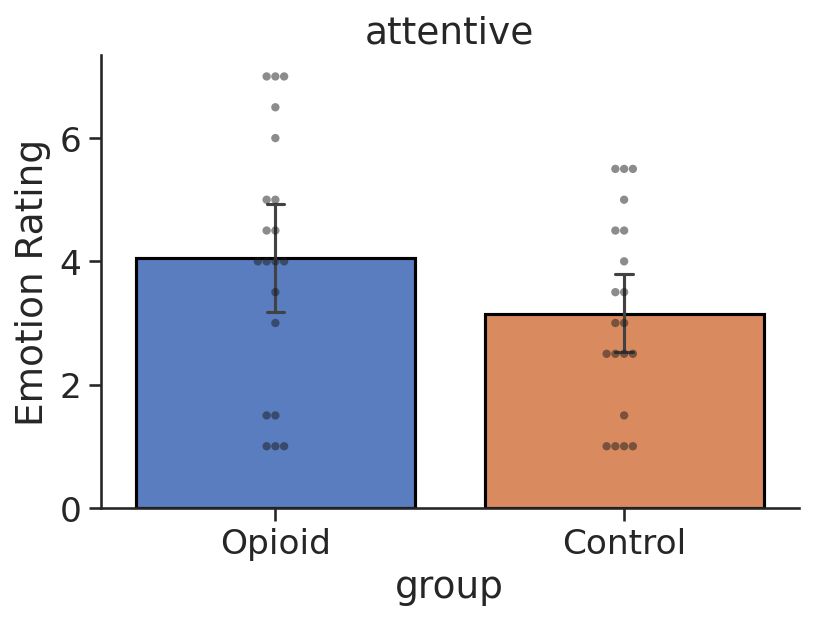

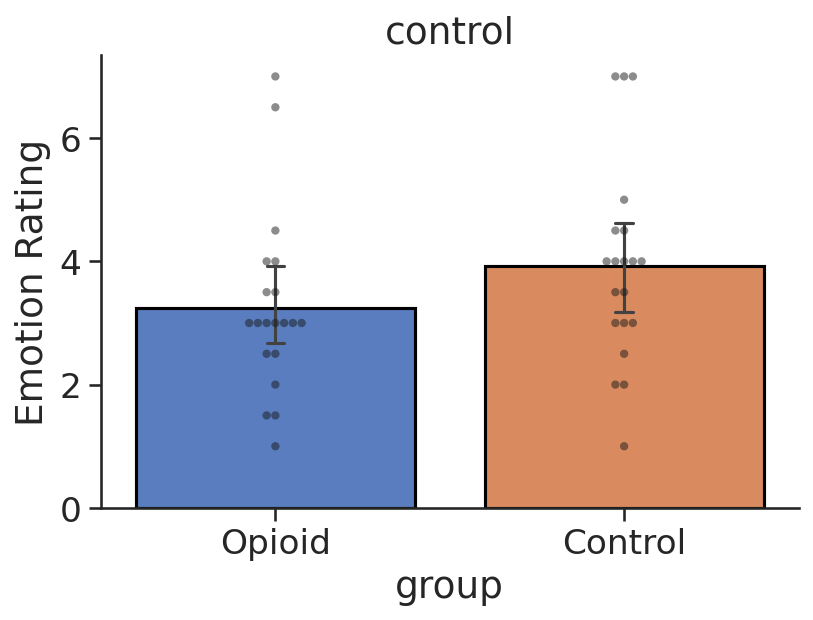

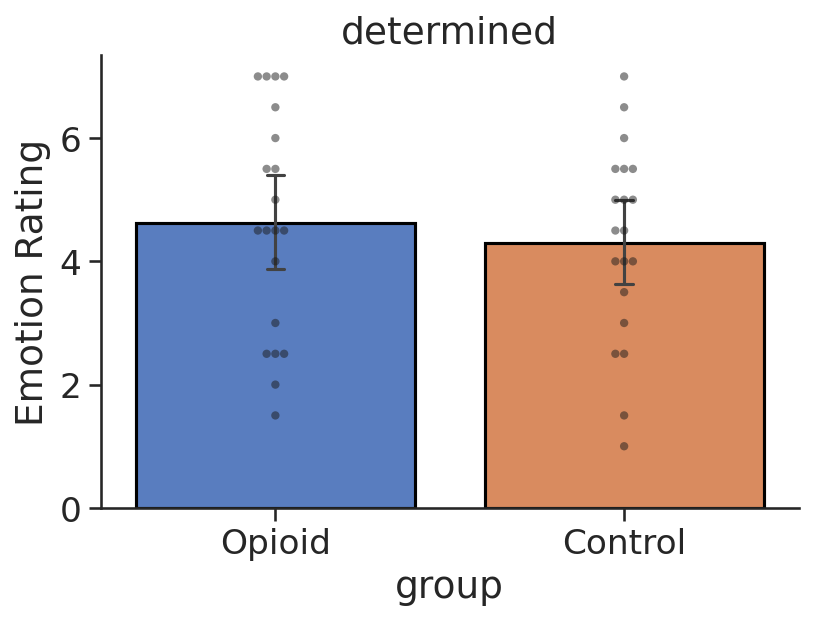

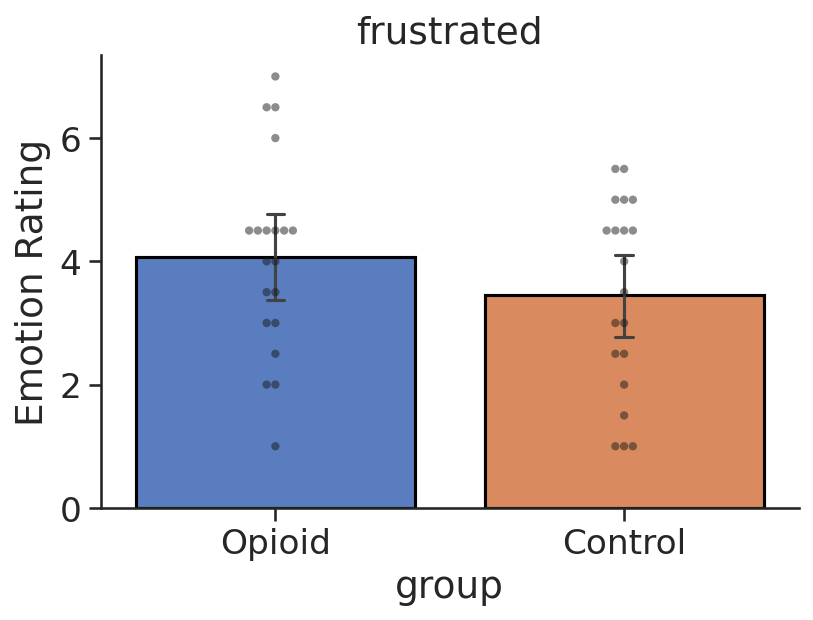

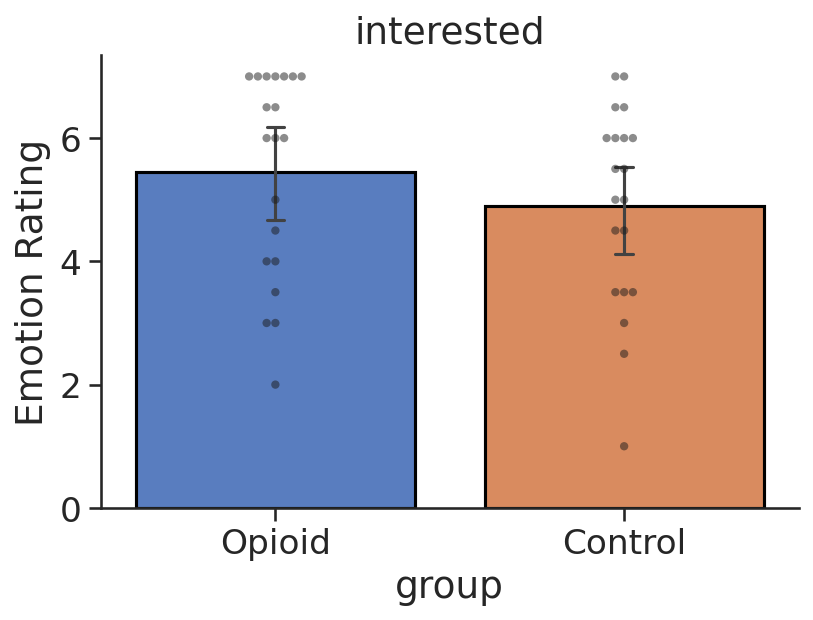

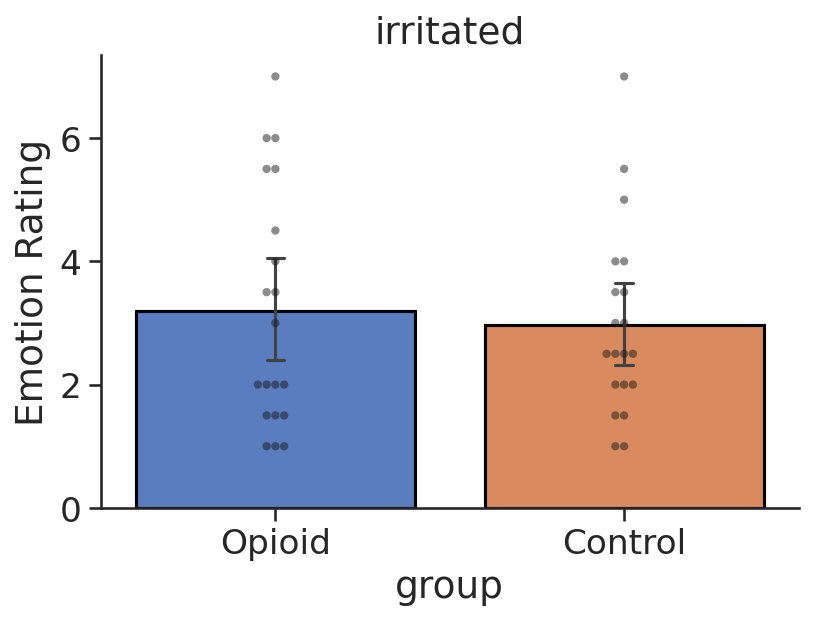

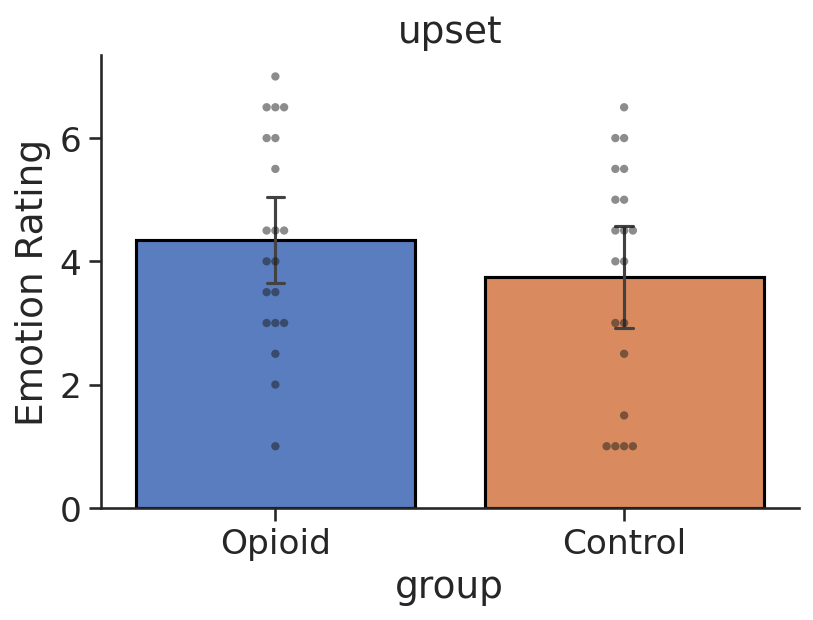

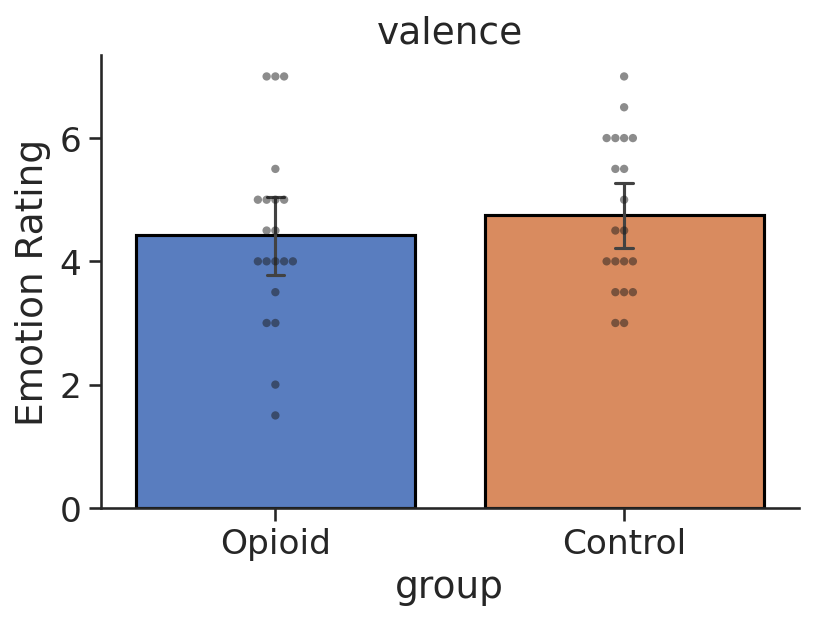

In [23]:
# collapse ratings for controllable and uncontrollable cues, then plot
emocollapsed = emoratings.groupby(['Subject','Emotion','group'],as_index=False).mean()
restruct_emo = emocollapsed.pivot(index='Subject', columns='Emotion', values='QuestRating').reset_index()
restruct_emo = restruct_emo.rename_axis(None,axis=1)
restruct_emo['negemo'] = (restruct_emo['upset']+restruct_emo['frustrated']+restruct_emo['irritated'])/3
restruct_emo['posemo'] = (restruct_emo['attentive']+restruct_emo['determined']+restruct_emo['interested'])/3
restruct_behavemo = sm_restruct_behav_df.merge(restruct_emo,how='left',left_on='subject',right_on='Subject')
restruct_behavemo.to_csv('restruct_behavemo.csv')

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rcParams['figure.dpi']= 150

sns.set(font_scale=1.5)
sns.set_style("white")
sns.set_style("ticks")
sns.set_palette("muted") #color codes from colorbrewer2.org


for emo in emocollapsed['Emotion'].unique():
    fig,ax = plt.subplots(nrows=1, ncols=1)
    sns.barplot(x="group", y="QuestRating", data=emocollapsed.loc[emoratings['Emotion']==emo,:].dropna(), ax=ax,
                     errwidth=1.5,capsize=.05, alpha=1, order=patient_group_list, **{"edgecolor":"black", "linewidth":1.5})

    sns.swarmplot(x="group", y="QuestRating", data=emocollapsed.loc[emoratings['Emotion']==emo,:].dropna(), ax=ax, size = 4,
                  order=patient_group_list, dodge=True, color="k", alpha=.5)
    ax.set_title(emo)
    ax.set_ylabel("Emotion Rating")
    sns.despine()
    fig.savefig("emotion_%s.jpg" % emo, bbox_inches="tight")

### Emotion rating group t-tests
- no main effect of group

In [22]:
# group t-tests and CIs of difference
for emo in ['valence','negemo','posemo']:
    DV=emo
    x = restruct_behavemo.loc[restruct_behavemo['group']==patient_group_list[0],DV].dropna()
    y = restruct_behavemo.loc[restruct_behavemo['group']==patient_group_list[1],DV].dropna()
    std_xy = sqrt(((x.shape[0] - 1)*(x.std())**2 + (y.shape[0] - 1)*(y.std())**2) / (x.shape[0]+y.shape[0]-2) )
    MoE = stats.t.ppf([0.975], x.shape[0]+y.shape[0]-2) * std_xy * sqrt(1/x.shape[0] + 1/y.shape[0] )
    mdiff = np.mean(y)-np.mean(x)
    t,p = stats.ttest_ind(x,y)
    pperm = permutation_test(x.values, y.values,func= lambda x, y: abs(np.mean(y)-np.mean(x)),method='approximate',seed=0,num_rounds=100000)
    d = cohen_d(x,y)
    print ('Ctl %s: m = %.3f, sd = %.3f' % (emo, np.mean(y)-4, np.std(y)))
    print ('Opioid %s: m = %.3f, sd = %.3f' % (emo, np.mean(x)-4, np.std(x)))
    print ('Ctl-Opioid %s: mdiff=%.4f, CI=[%.4f,%.4f], t= %.4f, p= %.4f, pperm=%.4f, d = %.4f' % (emo,mdiff,mdiff-MoE,mdiff+MoE,t,p,pperm,d))

Ctl valence: m = -0.075, sd = 1.599
Opioid valence: m = -0.750, sd = 1.445
Ctl-Opioid valence: mdiff=0.6750, CI=[-0.3259,1.6759], t= -1.3653, p= 0.1802, pperm=0.1638, d = -0.4317
Ctl negemo: m = -0.550, sd = 1.418
Opioid negemo: m = 0.158, sd = 1.548
Ctl-Opioid negemo: mdiff=-0.7083, CI=[-1.6833,0.2667], t= 1.4707, p= 0.1496, pperm=0.1456, d = 0.4651
Ctl posemo: m = 0.650, sd = 1.169
Opioid posemo: m = 0.833, sd = 1.459
Ctl-Opioid posemo: mdiff=-0.1833, CI=[-1.0515,0.6848], t= 0.4275, p= 0.6714, pperm=0.6759, d = 0.1352


In [38]:
#one sample t-test valence
data = restruct_behavemo.loc[:,'valence'].dropna()
mdiff = np.mean(data)-4
stdev = np.std(data)
t,p = stats.ttest_1samp(data,4)
d = mdiff/(data.std())
from statsmodels.stats import weightstats as sms
difference = sms.DescrStatsW(data)
print (difference.ttest_mean())
print (difference.tconfint_mean())
print ('all valence versus zero: mdiff=%.4f,stdev=%.4f, t= %.4f, p= %.4f, d = %.4f' % (mdiff,stdev,t,p,d))


(14.354141215034986, 3.757286823892713e-17, 39.0)
(3.0819731602439755, 4.093026839756025)
all valence versus zero: mdiff=-0.4125,stdev=1.5608, t= -1.6505, p= 0.1069, d = -0.2610


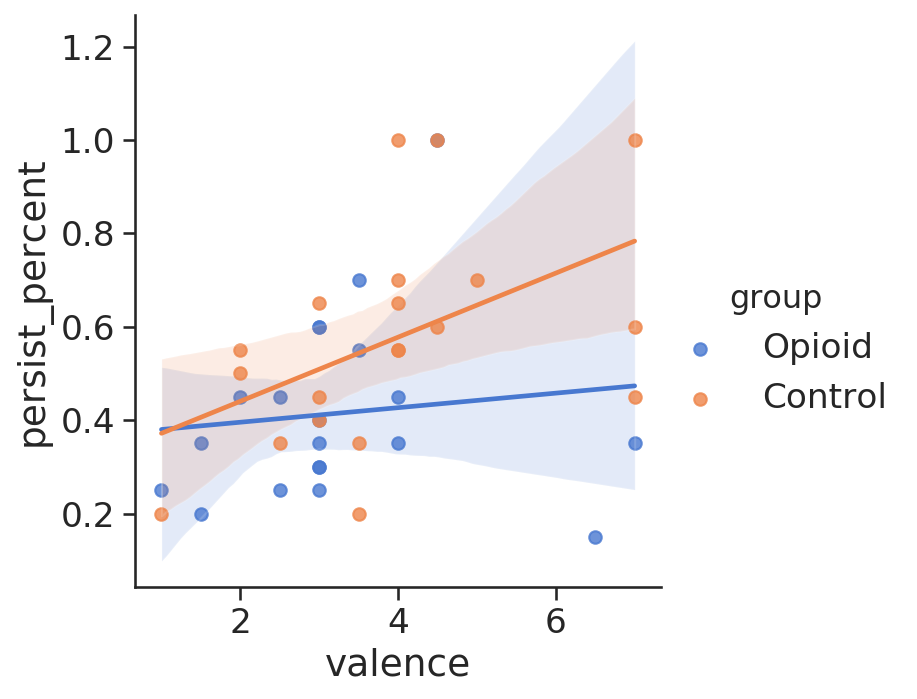

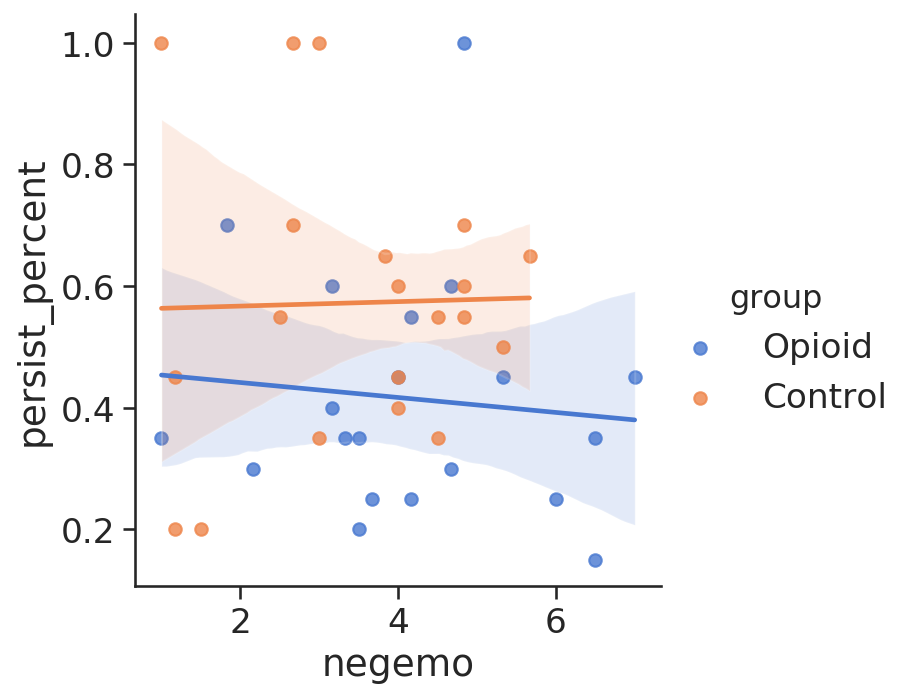

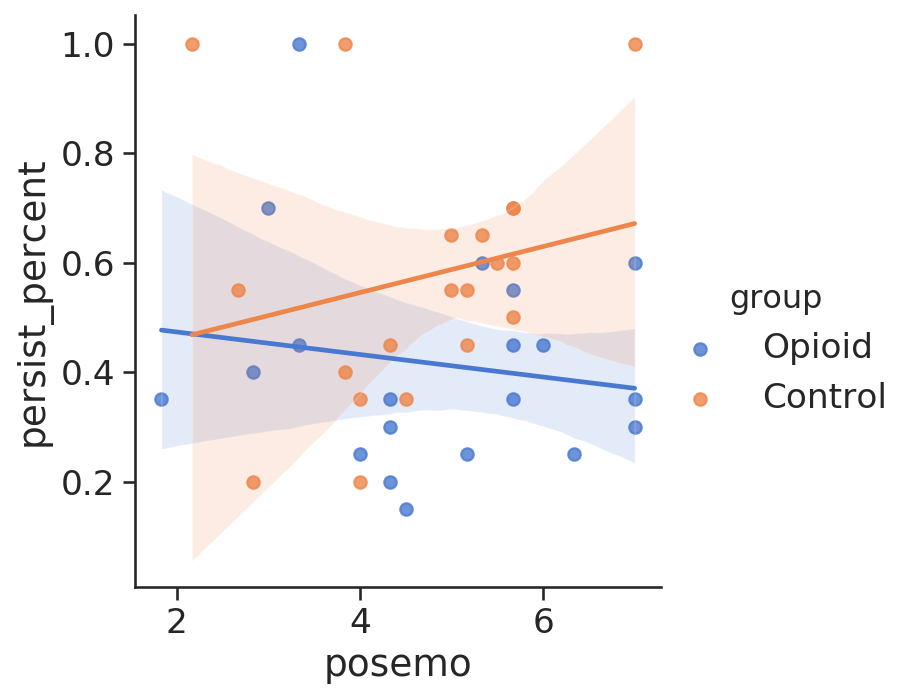

In [29]:
# emo by persist scatter
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rcParams['figure.dpi']= 150

sns.set(font_scale=1.5)
sns.set_style("white")
sns.set_style("ticks")
sns.set_palette("muted") #color codes from colorbrewer2.org


for emo in ['valence','negemo','posemo']:
    sns.lmplot(x=emo,y='persist_percent',hue='group',data=restruct_behavemo)
#     plt.gca().set_title('%s controllable setbacks' % emo)
    sns.despine()


In [35]:
# correlation between emo and persistence
xy=restruct_behavemo.loc[restruct_behavemo['group']=='Control',['persist_percent','valence']].dropna()
x=xy.iloc[:,0].values
y=xy.iloc[:,1].values
print("CONTROLS\nspearman:")
print(stats.spearmanr(x,y))
p_value = permutation_test(x, y,
                           method='approximate',num_rounds=10000,
                           func=lambda x, y: stats.pearsonr(x, y)[0],
                           seed=0)
print("permutation based pearson (prob of correlation as large under null:")
print(p_value)

xy=restruct_behavemo.loc[restruct_behavemo['group']=='Opioid',['persist_percent','valence']].dropna()
x=xy.iloc[:,0].values
y=xy.iloc[:,1].values
print("OPIOID\nspearman:")
print(stats.spearmanr(x,y))
p_value = permutation_test(x, y,
                           method='approximate',num_rounds=10000,
                           func=lambda x, y: stats.pearsonr(x, y)[0],
                           seed=0)
print("permutation based pearson (prob of correlation as large under null:")
print(p_value)

xy=restruct_behavemo.loc[:,['persist_percent','valence']].dropna()
x=xy.iloc[:,0].values
y=xy.iloc[:,1].values
print("ALL\nspearman:")
print(stats.spearmanr(x,y))
p_value = permutation_test(x, y,
                           method='approximate',num_rounds=10000,
                           func=lambda x, y: stats.pearsonr(x, y)[0],
                           seed=0)
print("permutation based pearson (prob of correlation as large under null:")
print(p_value)

CONTROLS
spearman:
SpearmanrResult(correlation=0.5885401613652488, pvalue=0.0063364925314374956)
permutation based pearson (prob of correlation as large under null:
0.0218
OPIOID
spearman:
SpearmanrResult(correlation=0.28220446144124306, pvalue=0.22801555729309644)
permutation based pearson (prob of correlation as large under null:
0.3003
ALL
spearman:
SpearmanrResult(correlation=0.47051130916657635, pvalue=0.0021850705058591674)
permutation based pearson (prob of correlation as large under null:
0.0121


OPIOID robust:


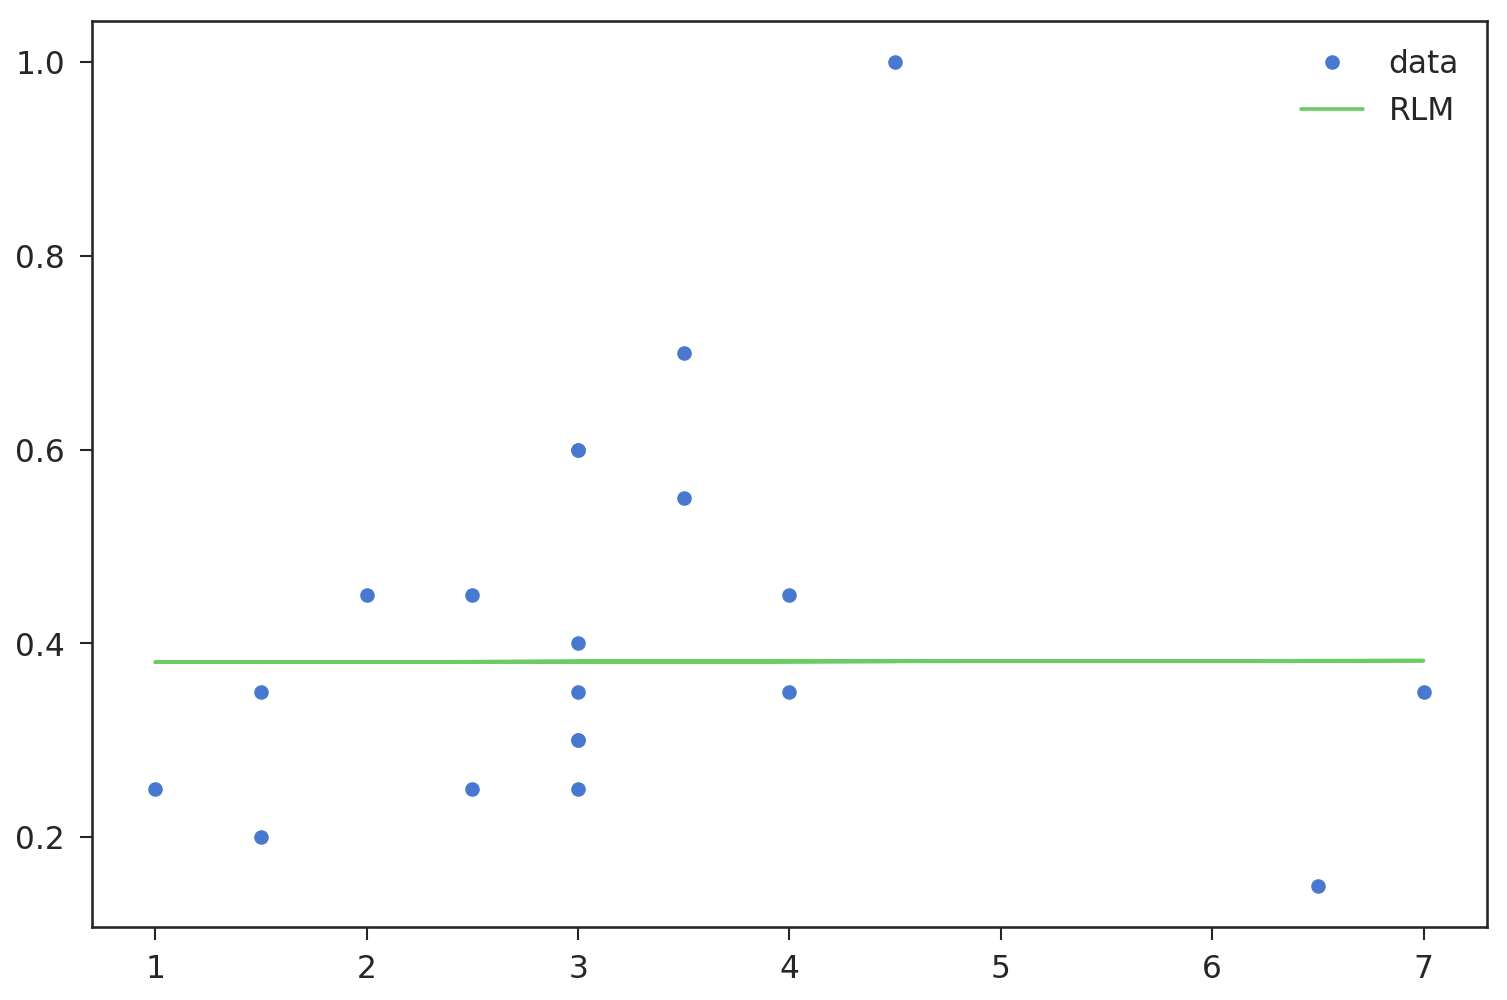

In [59]:
import statsmodels.api as sm
xy=restruct_behavemo.loc[restruct_behavemo['group']=='Opioid',['persist_percent','valence']].dropna()
y=xy.iloc[:,0].values
x=xy.iloc[:,1].values
print("OPIOID robust:")
xandcons = sm.add_constant(x)
huber_t = sm.RLM(y, xandcons, M=sm.robust.norms.TukeyBiweight())
hub_results = huber_t.fit()
hub_results.summary()

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(x, y, 'o',label="data")

ax.plot(x, hub_results.fittedvalues, label="RLM")
ax.legend(loc="best")


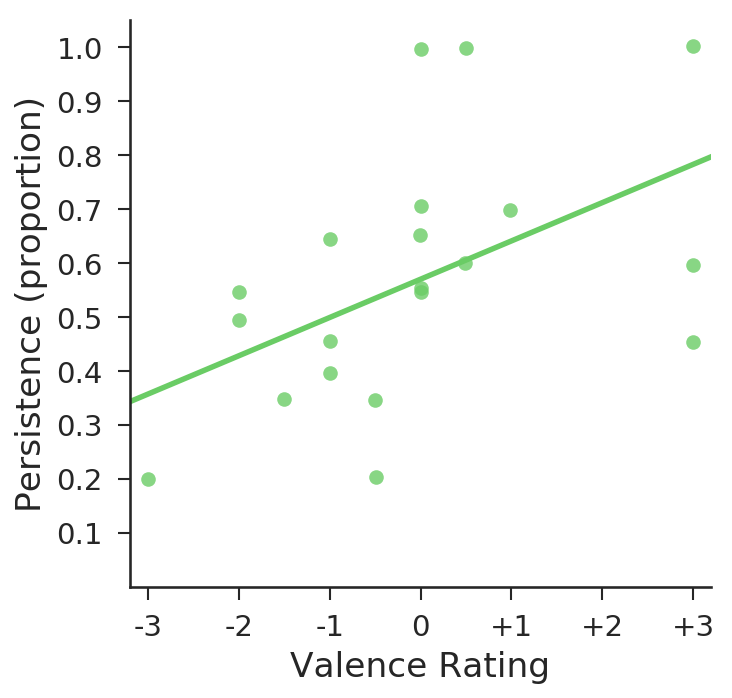

In [64]:
# emotion by persistence scatter
sns.set_style("white")
sns.set_style("ticks")

xy=restruct_behavemo.loc[restruct_behavemo['group']=='Control',['persist_percent','valence']].dropna()
x=xy.iloc[:,0].values
y=xy.iloc[:,1].values

fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, sharex=False)
fig.set_figwidth(5)
fig.set_figheight(5)

sns.regplot(x='valence',y='persist_percent',data=xy,ci=None, ax=ax, robust=True, color=sns.color_palette()[1],x_jitter=.01, y_jitter=.005)
sns.despine()
ax.set_ylabel('Persistence (proportion)')
ax.set_ylim([0,1.05])
ax.set_yticks([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0])

ax.set_xlabel('Valence Rating')
ax.set_xlim([.8,7.2])
ax.set_xticks([1,2,3,4,5,6,7])
ax.set_xticklabels(['-3','-2','-1','0','+1','+2','+3'])
ax.tick_params(axis='x',labelsize=14)
ax.tick_params(axis='y',labelsize=14)

fig.savefig('ctl_valence_by_%s.jpg' % 'persist',bbox_inches='tight')


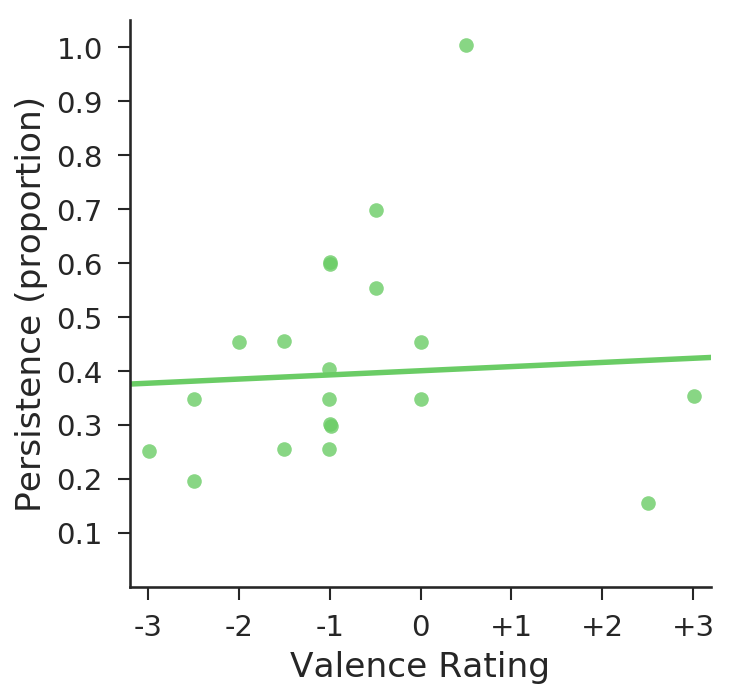

In [65]:
# emotion by persistence scatter

sns.set_style("white")
sns.set_style("ticks")

xy=restruct_behavemo.loc[restruct_behavemo['group']=='Opioid',['persist_percent','valence']].dropna()
x=xy.iloc[:,0].values
y=xy.iloc[:,1].values

fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, sharex=False)
fig.set_figwidth(5)
fig.set_figheight(5)

sns.regplot(x='valence',y='persist_percent',data=xy,ci=None, ax=ax, robust=True, color=sns.color_palette()[1],x_jitter=.01, y_jitter=.005)
sns.despine()
ax.set_ylabel('Persistence (proportion)')
ax.set_ylim([0,1.05])
ax.set_yticks([.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0])

ax.set_xlabel('Valence Rating')
ax.set_xlim([.8,7.2])
ax.set_xticks([1,2,3,4,5,6,7])
ax.set_xticklabels(['-3','-2','-1','0','+1','+2','+3'])
ax.tick_params(axis='x',labelsize=14)
ax.tick_params(axis='y',labelsize=14)

fig.savefig('po_valence_by_%s.jpg' % 'persist',bbox_inches='tight')


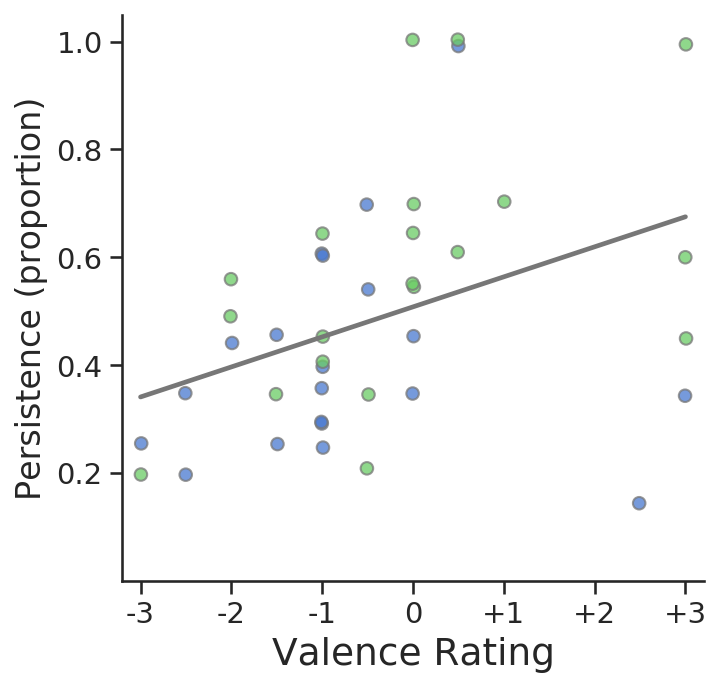

In [57]:
# emotion by persistence scatter
sns.set_style("white")
sns.set_style("ticks")

xy=restruct_behavemo.loc[:,['persist_percent','valence','group']].dropna()
x=xy.iloc[:,0].values
y=xy.iloc[:,1].values

fig, ax = plt.subplots(nrows=1, ncols=1, sharey=False, sharex=False)
fig.set_figwidth(5)
fig.set_figheight(5)

xy['color']= np.where( xy.group=='Opioid' , sns.color_palette().as_hex()[0], sns.color_palette().as_hex()[2])

sns.regplot(x='valence',y='persist_percent',data=xy,ci=None, ax=ax, robust=True, color="#777777",
            x_jitter=.01, y_jitter=.01, scatter_kws={'facecolors':xy['color'], 'alpha':.75})
sns.despine()
ax.set_ylabel('Persistence (proportion)',fontsize=16)
ax.set_ylim([0,1.05])
ax.set_yticks([.2,.4,.6,.8,1.0])

ax.set_xlabel('Valence Rating')
ax.set_xlim([.8,7.2])
ax.set_xticks([1,2,3,4,5,6,7])
ax.set_xticklabels(['-3','-2','-1','0','+1','+2','+3'])
ax.tick_params(axis='x',labelsize=14)
ax.tick_params(axis='y',labelsize=14)

fig.savefig('all_valence_by_%s.jpg' % 'persist',bbox_inches='tight', dpi=600)
